#### Heart Arrhythmia Detection from ECG waveform with Deep Learning model

----

## 2. Data distribution and Basic Statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import os
import sys
import glob
import tqdm
import random
import time
from itertools import cycle
import warnings
warnings.filterwarnings(action='ignore')

import wfdb

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc
from sklearn.preprocessing import label_binarize

In [6]:
# datapath
datapath = 'c:/users/MI2RL-KHJ/2022_Project/Signal/mit-bih-arrhythmia-database-1.0.0'
# mimic dataset 파일 구성: hea, atr, dat, xws
print(os.listdir(datapath))

['100.atr', '100.dat', '100.hea', '100.xws', '101.atr', '101.dat', '101.hea', '101.xws', '102-0.atr', '102.atr', '102.dat', '102.hea', '102.xws', '103.atr', '103.dat', '103.hea', '103.xws', '104.atr', '104.dat', '104.hea', '104.xws', '105.atr', '105.dat', '105.hea', '105.xws', '106.atr', '106.dat', '106.hea', '106.xws', '107.atr', '107.dat', '107.hea', '107.xws', '108.atr', '108.at_', '108.dat', '108.hea', '108.xws', '109.atr', '109.dat', '109.hea', '109.xws', '111.atr', '111.dat', '111.hea', '111.xws', '112.atr', '112.dat', '112.hea', '112.xws', '113.atr', '113.dat', '113.hea', '113.xws', '114.atr', '114.dat', '114.hea', '114.xws', '115.atr', '115.dat', '115.hea', '115.xws', '116.atr', '116.dat', '116.hea', '116.xws', '117.atr', '117.at_', '117.dat', '117.hea', '117.xws', '118.atr', '118.dat', '118.hea', '118.xws', '119.atr', '119.at_', '119.dat', '119.hea', '119.xws', '121.atr', '121.dat', '121.hea', '121.xws', '122.atr', '122.dat', '122.hea', '122.xws', '123.atr', '123.dat', '123.he

In [7]:
header_files = [os.path.basename(x) for x in glob.glob(os.path.join(datapath, '*.hea'))]
pids = sorted([x.split('.')[0] for x in header_files])

In [8]:
# annotation 파일 불러와서 label의 분포 확인
df = pd.DataFrame()

for pid in pids:
    file = os.path.join(datapath, pid)
    annotation = wfdb.rdann(os.path.join(file), 'atr')
    symbols = annotation.symbol
    
    values, cnts = np.unique(symbols, return_counts=True)
    df_sub = pd.DataFrame({'symbol': values, 'value': cnts, 'pid':[pid] * len(cnts)})
    df = pd.concat([df, df_sub], axis=0)

In [9]:
# Annotation 파일의 분포
df.groupby('symbol').value.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: value, dtype: int64

In [10]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [11]:
# normal, abnormal, nonbeat의 비율 구성 확인
df['type'] = -1 # nonbeat
df.loc[df.symbol == 'N', 'type'] = 0 # normal
df.loc[df.symbol.isin(abnormal), 'type'] = 1 # abnormal

In [12]:
df['type2'] = 'Non-beat' # nonbeat
df.loc[df.symbol == 'N', 'type2'] = 'Normal' # normal
df.loc[df.symbol.isin(abnormal), 'type2'] = 'Abnormal' # abnormal

In [13]:
df.groupby('type2').value.sum()

type2
Abnormal    34409
Non-beat     3186
Normal      75052
Name: value, dtype: int64

#### Define ECG data loading function

In [16]:
# load single patient's ecg signal and annotation
def load_ecg(file):
    """
    wfdb.rdrecord 를 이용해서 ecg 파일을 읽어옵니다.
    """
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_index = annotation.sample
    
    return p_signal, atr_sym, atr_index

# p_signal = raw ecg signal
# atr_sym = annotation symbol
# atr_sample = annotation index

In [144]:
# def ecg_plotting(pid, sec, randsample, ecg_type):
    
#     file = os.path.join(datapath, pid) #pid=pids[0]
#     fig_ = pid + '_' + ecg_type + '_' + str(sec) + 's' # + '.jpg'
#     p_signal, atr_sym, atr_sample = load_ecg(file)
    
#     values, counts = np.unique(atr_sym, return_counts = True)
#     for v, c in zip(values, counts):
#         print(v, c)
        
#     ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal]
#     n_index =  [b for a,b in zip(atr_sym,atr_sample) if not a in abnormal]
#     # ab_index, n_index
#     print('abnormal counts: ', len(ab_index), 'normal counts: ', len(n_index))
    
#     if ecg_type == 'abnormal':
#         tmp_index = ab_index
    
#     else:
#         tmp_index = n_index   
        
#     if randsample < len(tmp_index): 
#         tmp_index = random.sample(tmp_index, randsample)    
#         yplt = randsample+1 
#     else:
#         yplt = len(tmp_index)+1
    
#     print(tmp_index)
    

#     x = np.arange(len(p_signal))
#     fig = plt.figure(figsize=(10, yplt*2))
#     # fig = plt.gcf()
#     #, fontsize=14)
#     st = fig.suptitle(fig_)    
    
#     if ecg_type == 'abnormal':    
#         for i in range(1,(len(tmp_index)+1)):
            
#             try:
#                 left = tmp_index[i-1]-(360*sec) # 전 sec 초
#                 right = tmp_index[i-1]+(360*sec) # 후 sec 초

#                 plt.subplot(yplt,1, i)
#                 type_index_tmp = tmp_index[i-1]

#                 plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
#                 plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
#                 plt.plot(x[type_index_tmp],p_signal[type_index_tmp,0],'ro',label='abnormal')

#                 plt.xlim(left,right)
#                 plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
#             except:
#                 pass

#     else: 
#         for i in range(1,(len(tmp_index)+1)):
            
#             try:
#                 left = tmp_index[i-1]-(360*sec) # 전 sec 초
#                 right = tmp_index[i-1]+(360*sec) # 후 sec 초

#                 plt.subplot(yplt,1, i)
#                 type_index_tmp = tmp_index[i-1]

#                 plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
#                 plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
#                 # plt.plot(x[type_index_tmp],p_signal[type_index_tmp,0],'go',label='normal')

#                 plt.xlim(left,right)
#                 plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
#             except:
#                 pass    
    
    
#     plt.xlabel('time index')
#     plt.ylabel('ECG signal')    
#     # plt.title(ecg_type)#, ' plots')
#     plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
#     st.set_y(0.875)
#     fig.subplots_adjust(top=0.85)
#     fig.savefig(os.path.join(r'C:\Users\cogreen\Projects\signal\fig', fig_ +'.jpg'))

+ 1
A 33
N 2239
V 1
abnormal counts:  34 normal counts:  2240
[433841, 351481, 593068, 566259, 520982]


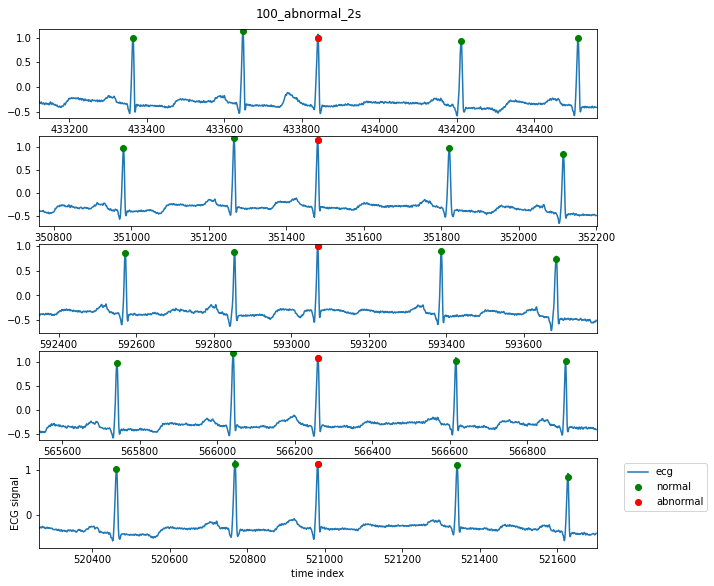

In [140]:
ecg_plotting(pids[0], 2, 5, 'abnormal')

+ 1
A 33
N 2239
V 1
abnormal counts:  34 normal counts:  2240
[455588, 311199, 448264, 17657, 188763]
+ 1
A 3
N 1860
Q 2
| 4
~ 4
abnormal counts:  3 normal counts:  1871
[86683, 394773, 66564, 95864, 523562]
+ 5
/ 2028
N 99
V 4
f 56
abnormal counts:  2088 normal counts:  104
[58215, 610218, 44650, 59638, 34216]
+ 1
A 2
N 2082
~ 6
abnormal counts:  2 normal counts:  2089
[381872, 305644, 74166, 113558, 300924]
+ 45
/ 1380
N 163
Q 18
V 2
f 666
~ 37
abnormal counts:  2048 normal counts:  263
[106039, 52496, 209282, 230427, 103751]
+ 1
N 2526
Q 5
V 41
| 30
~ 88
abnormal counts:  41 normal counts:  2650
[451046, 515435, 634571, 541978, 119737]
+ 41
N 1507
V 520
~ 30
abnormal counts:  520 normal counts:  1578
[138461, 124645, 188209, 330368, 173599]
+ 1
/ 2078
V 59
~ 2
abnormal counts:  2137 normal counts:  3
[47, 447030, 447756]
+ 1
A 4
F 2
N 1739
V 17
j 1
x 11
| 8
~ 41
abnormal counts:  24 normal counts:  1800
[498150, 371429, 366090, 327161, 177286]
+ 1
F 2
L 2492
V 38
~ 2
abnormal counts

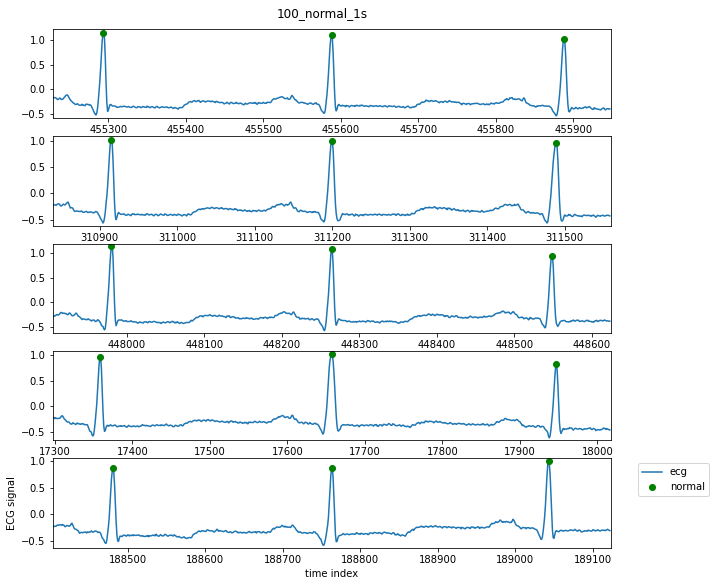

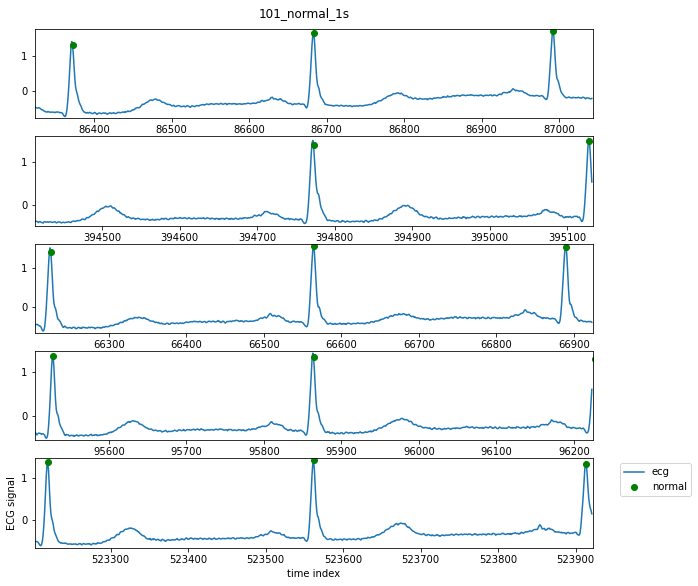

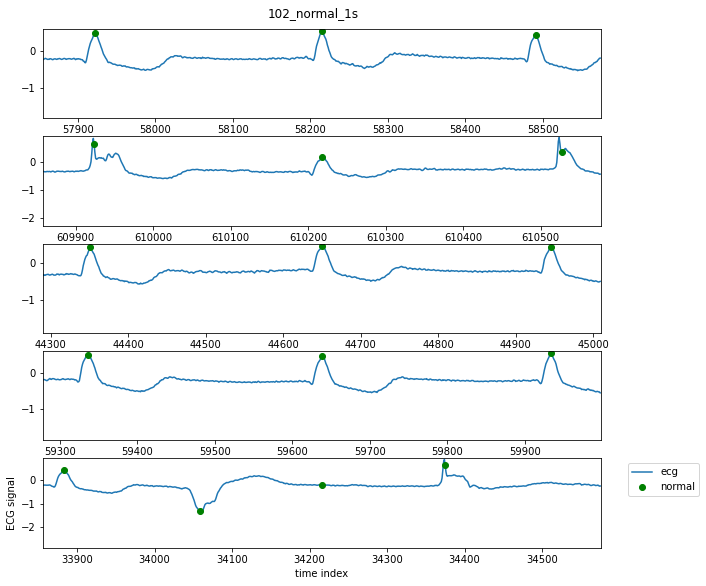

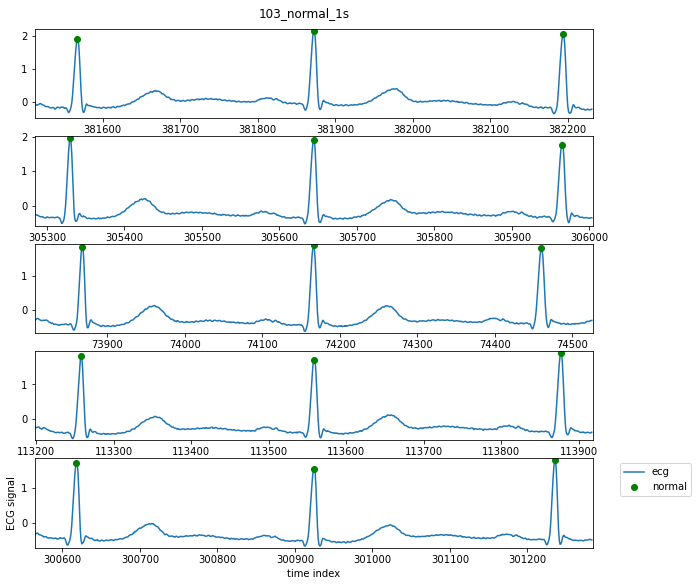

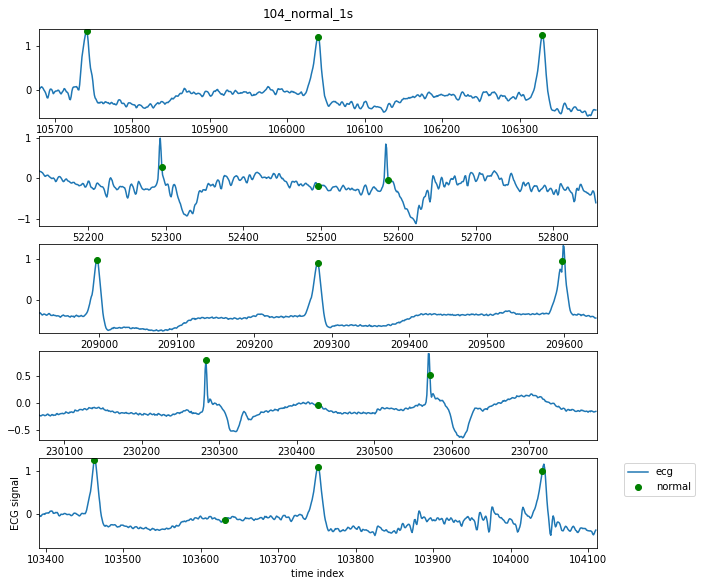

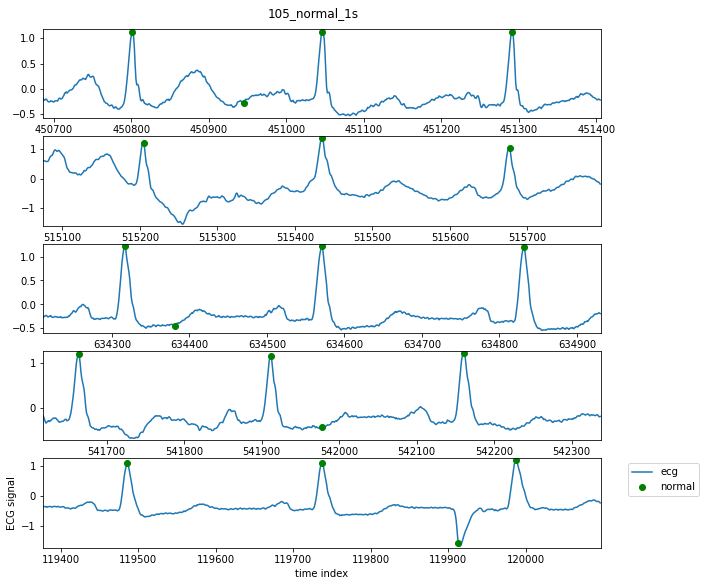

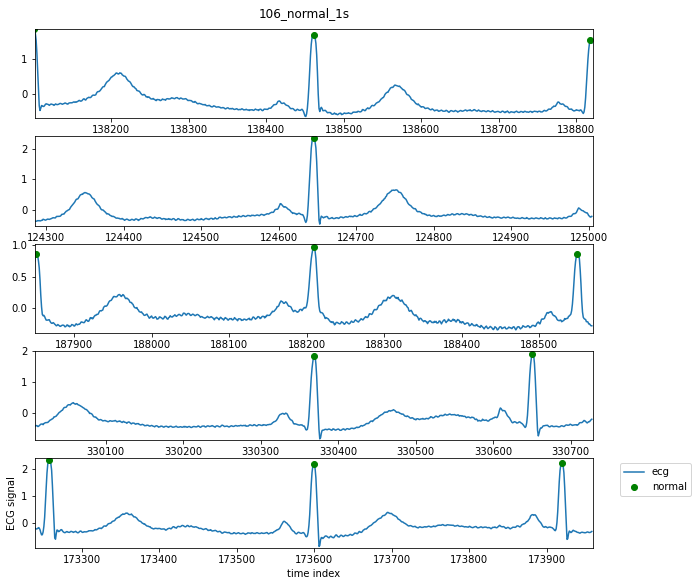

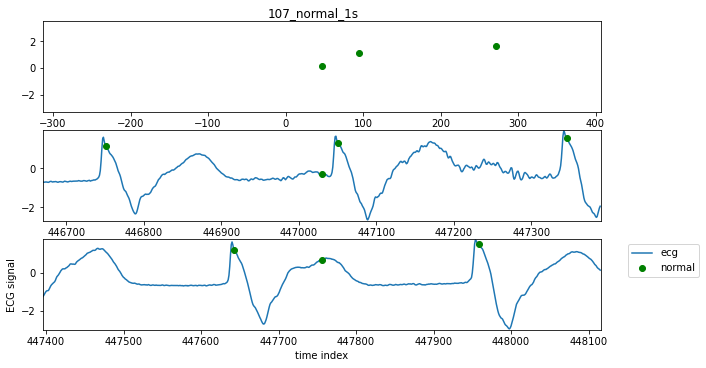

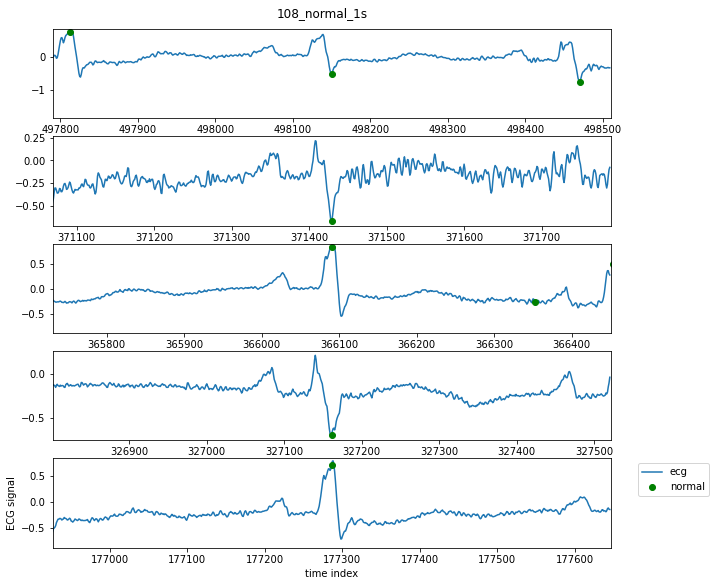

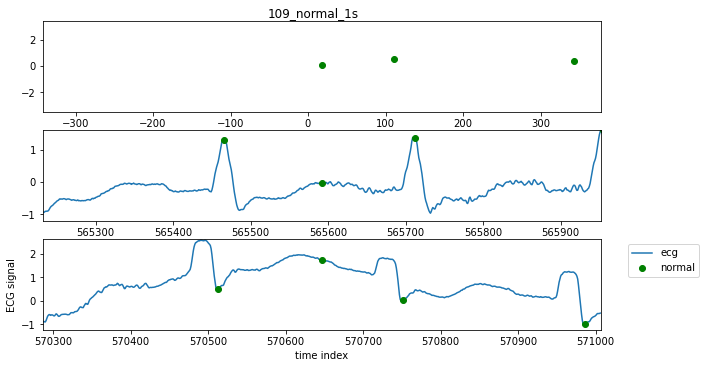

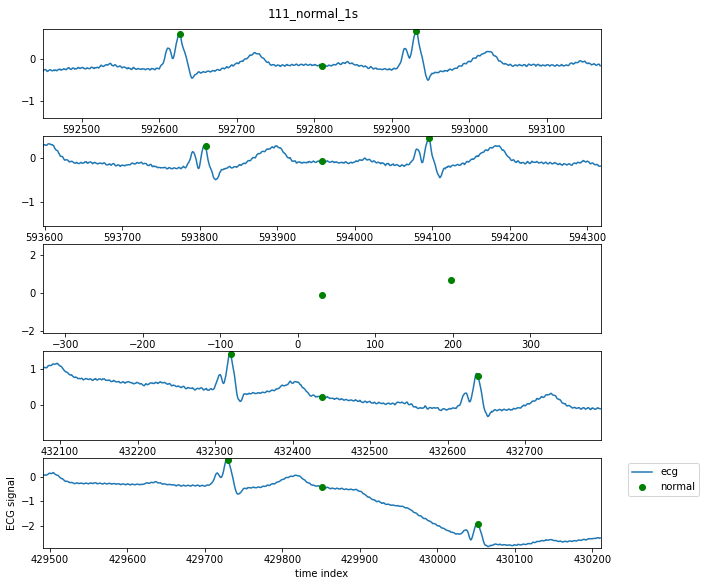

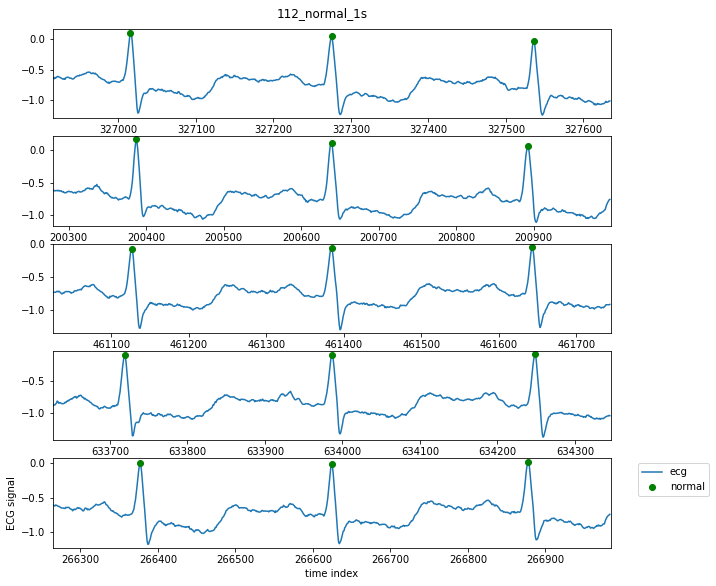

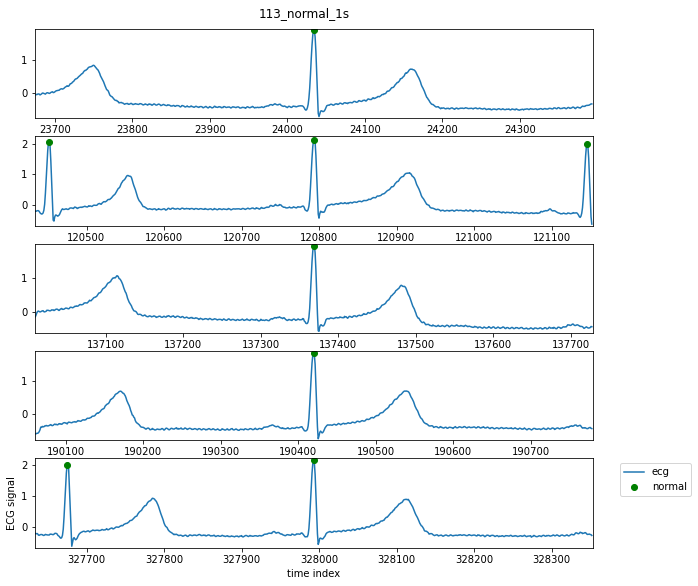

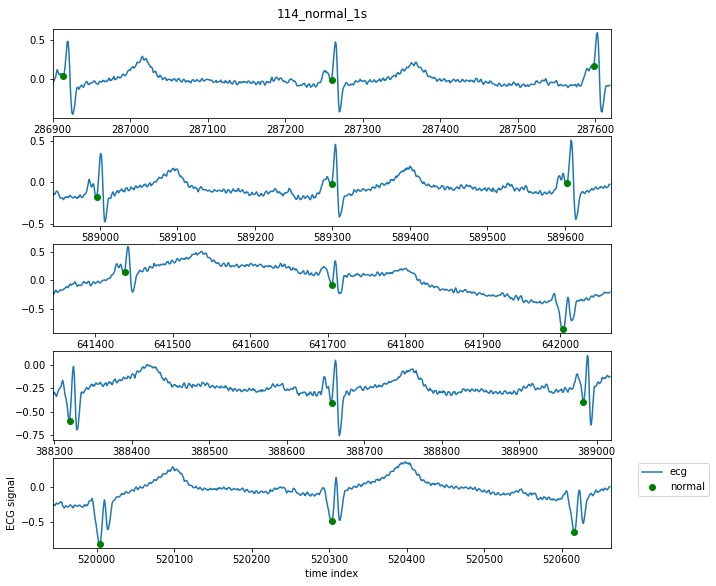

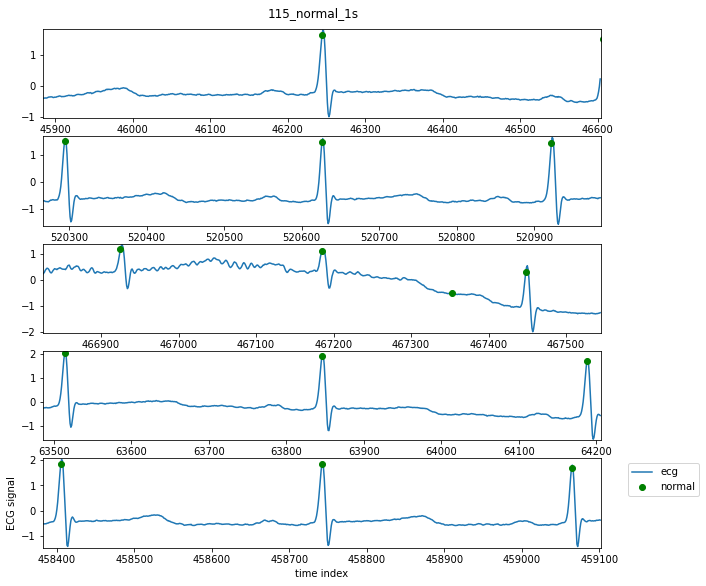

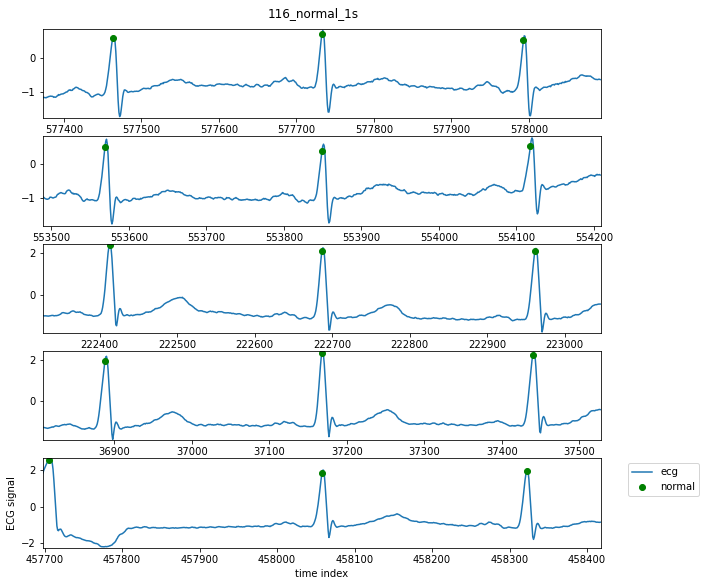

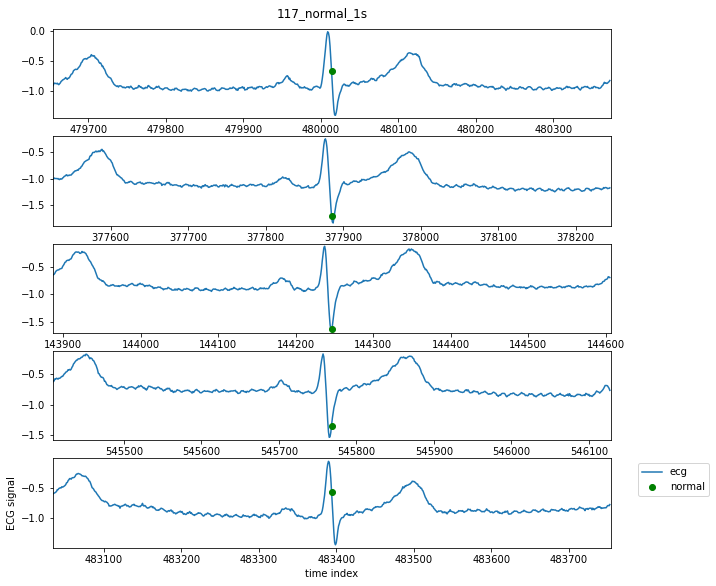

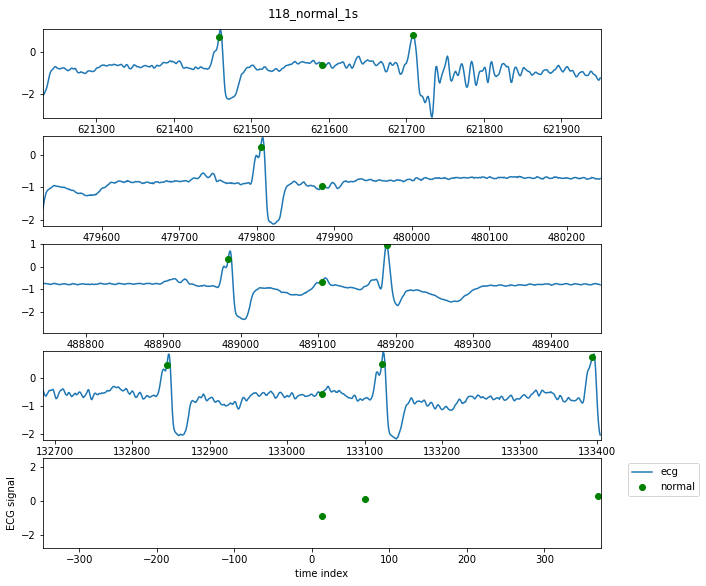

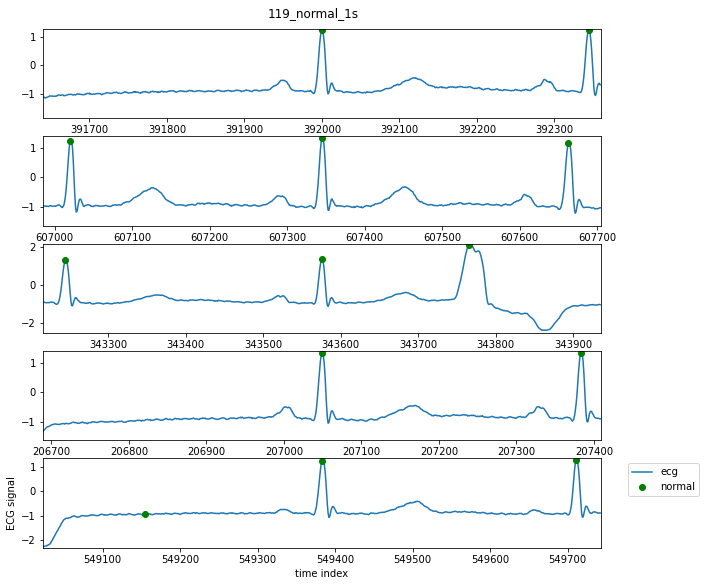

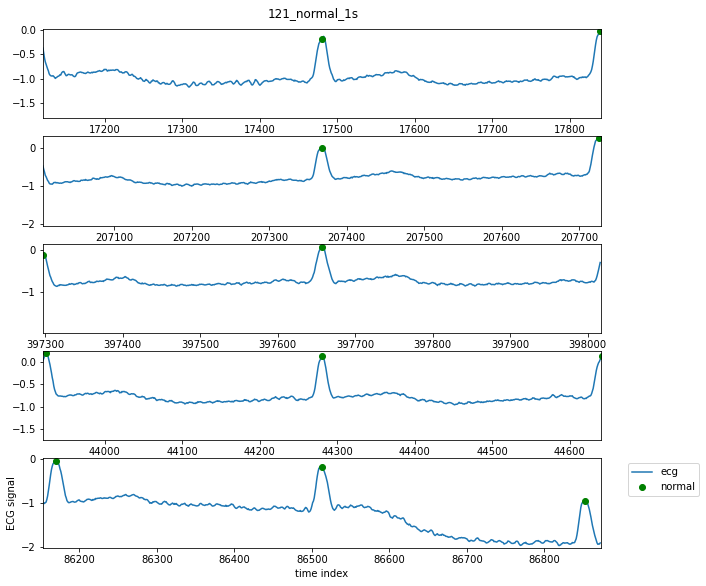

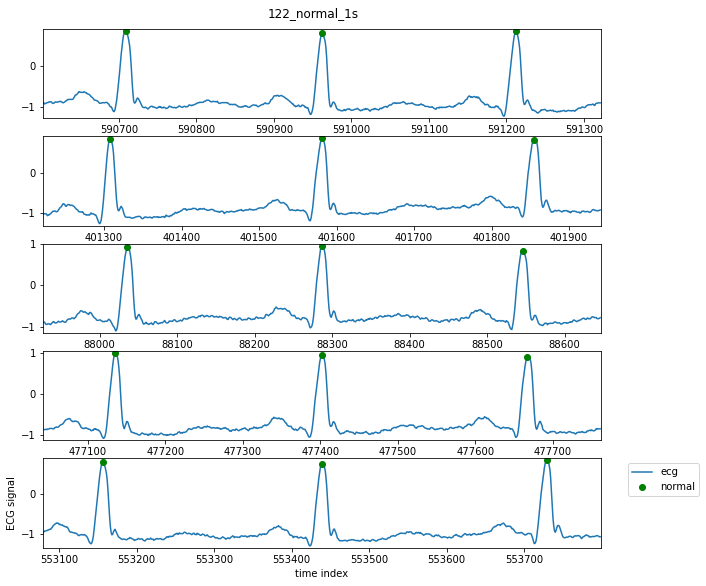

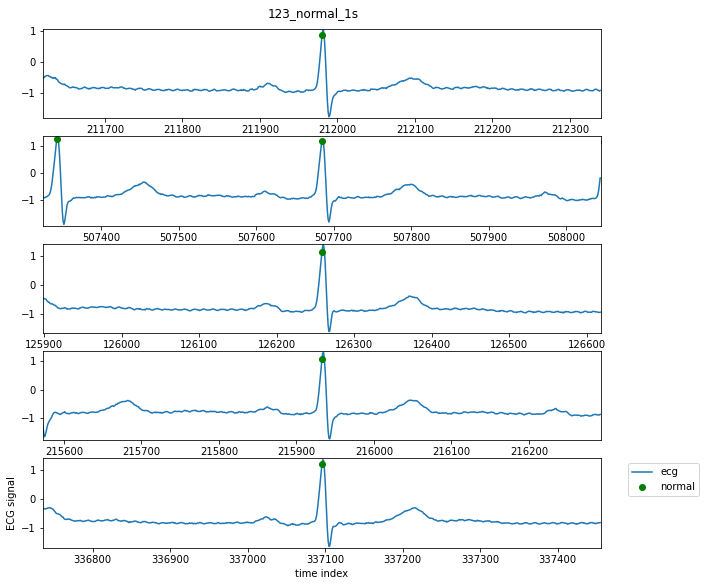

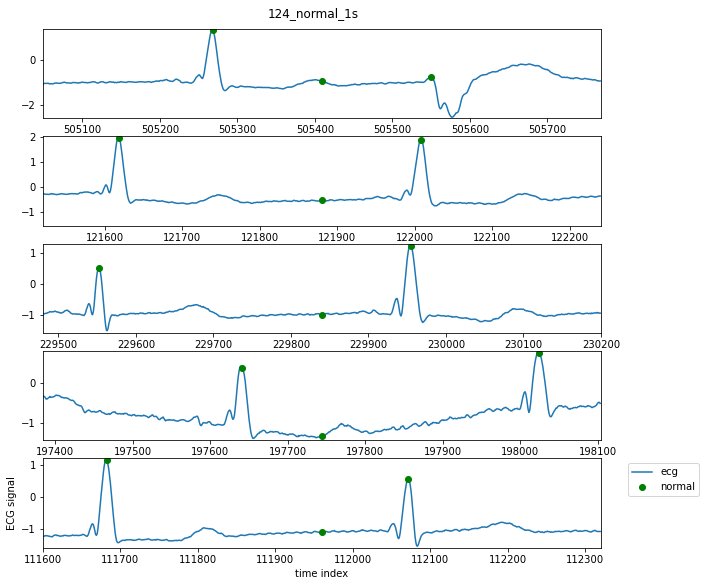

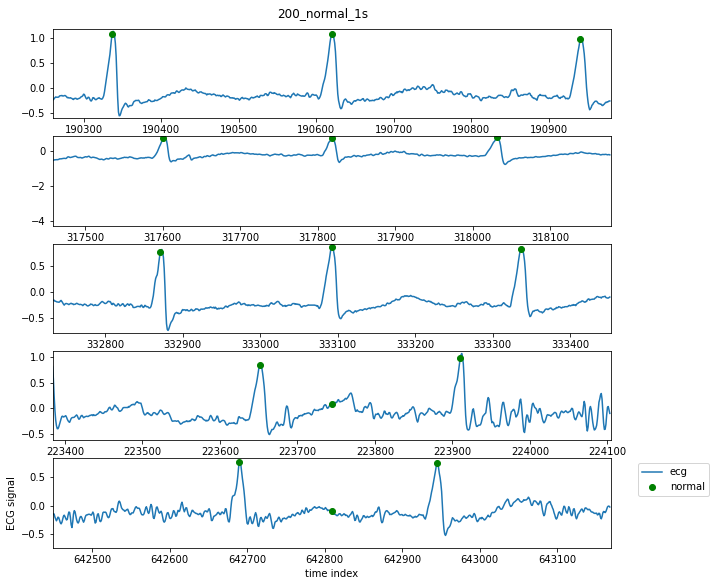

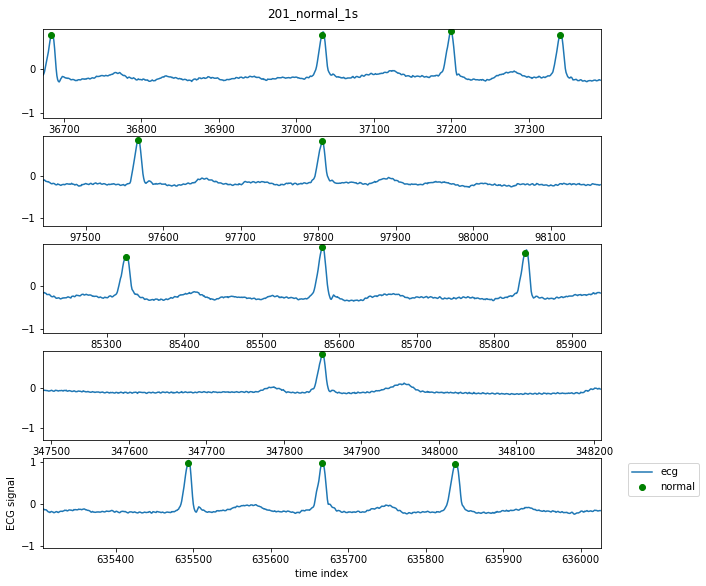

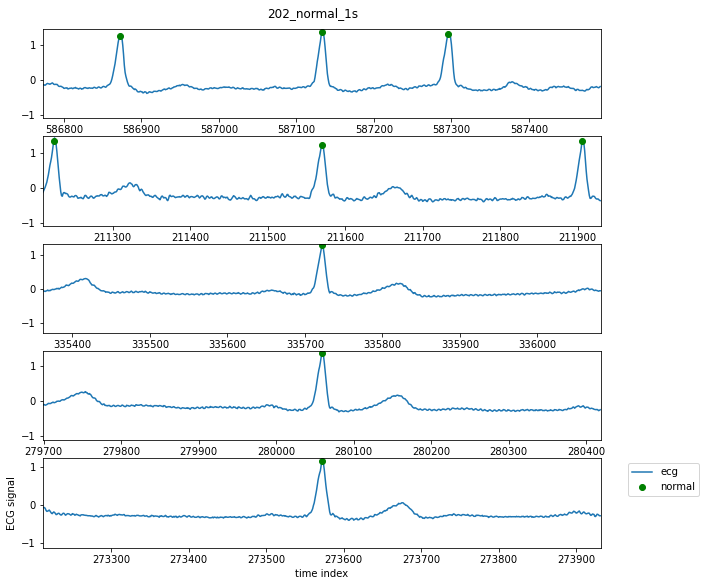

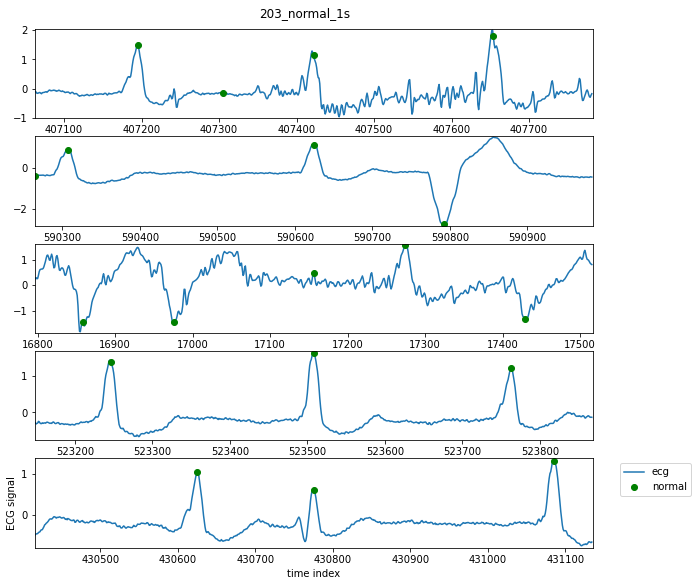

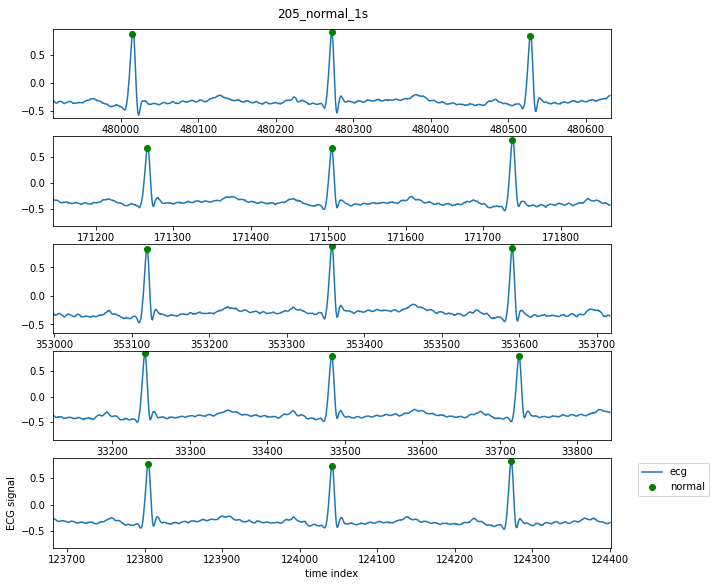

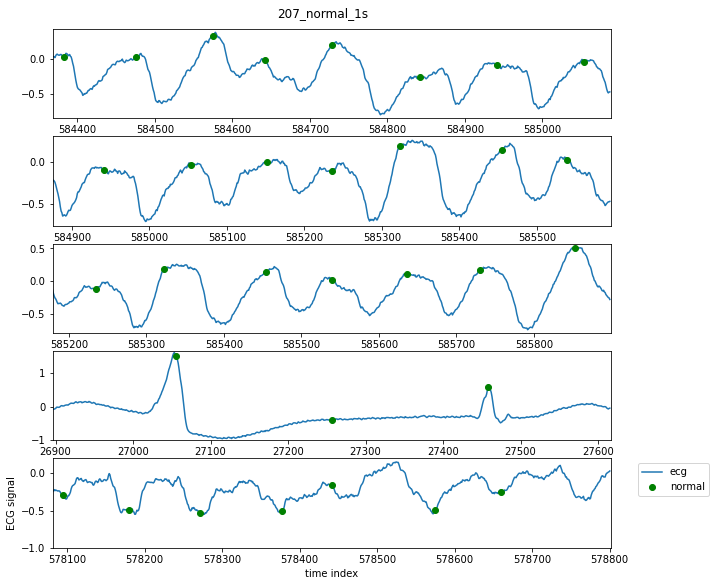

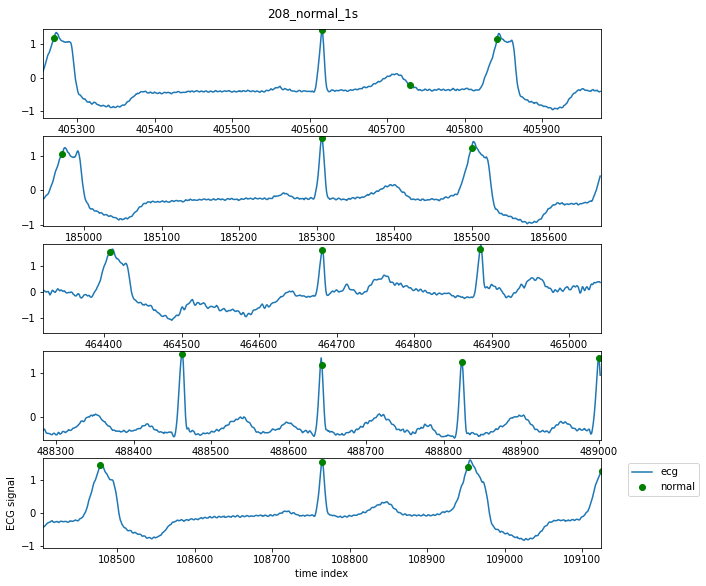

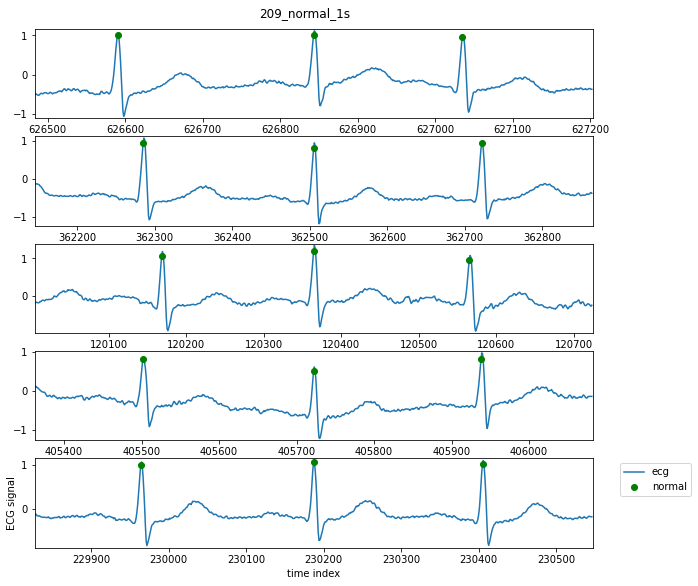

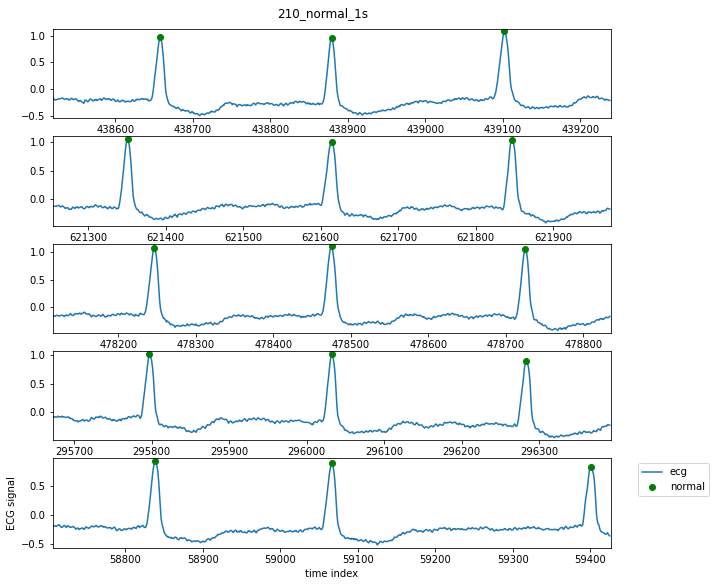

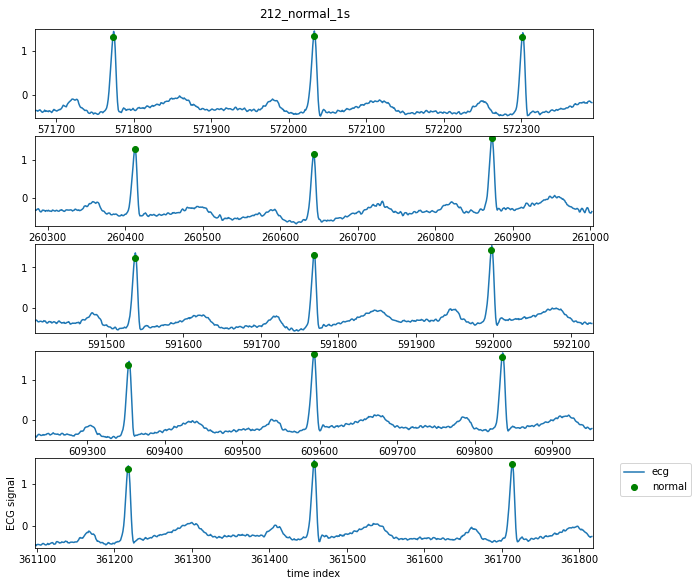

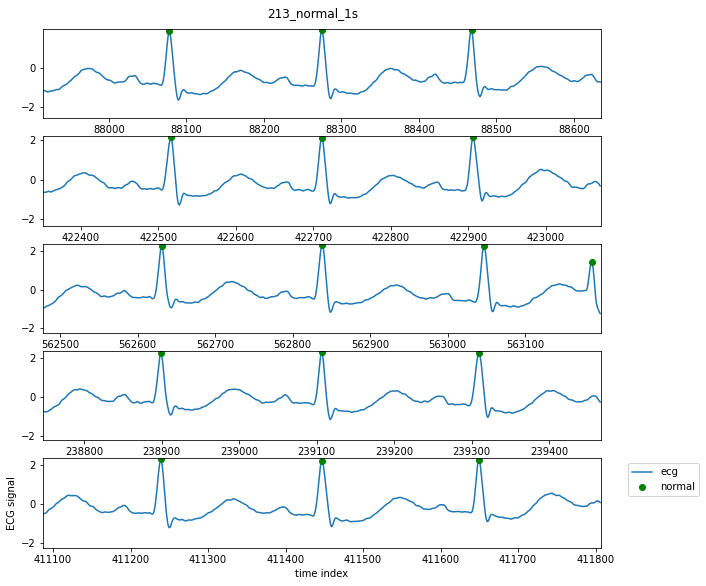

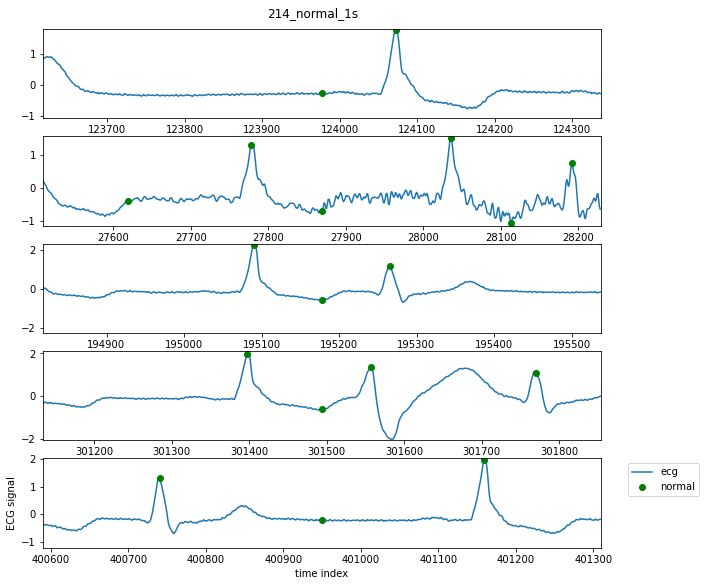

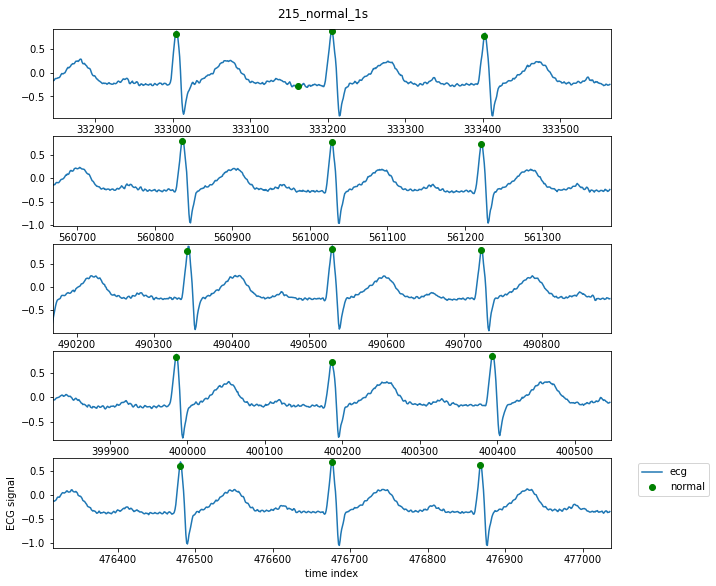

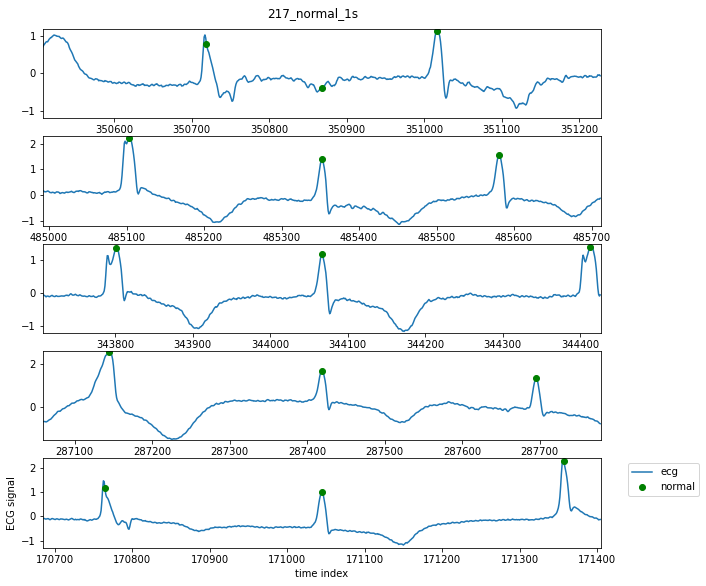

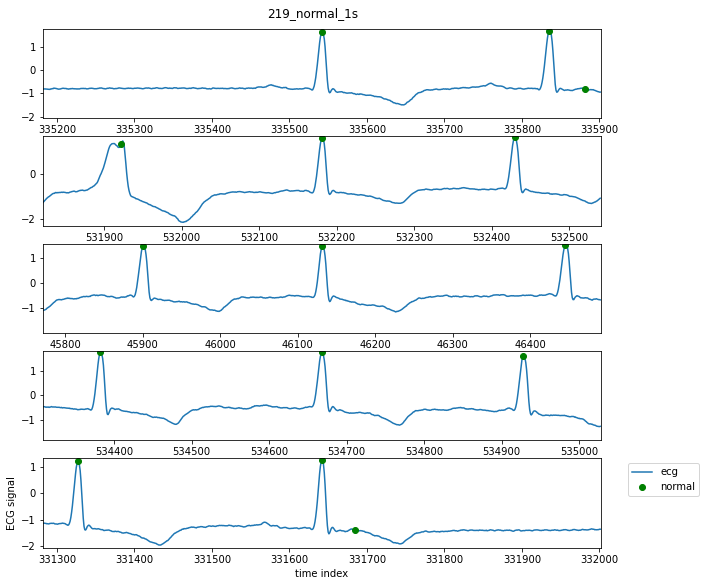

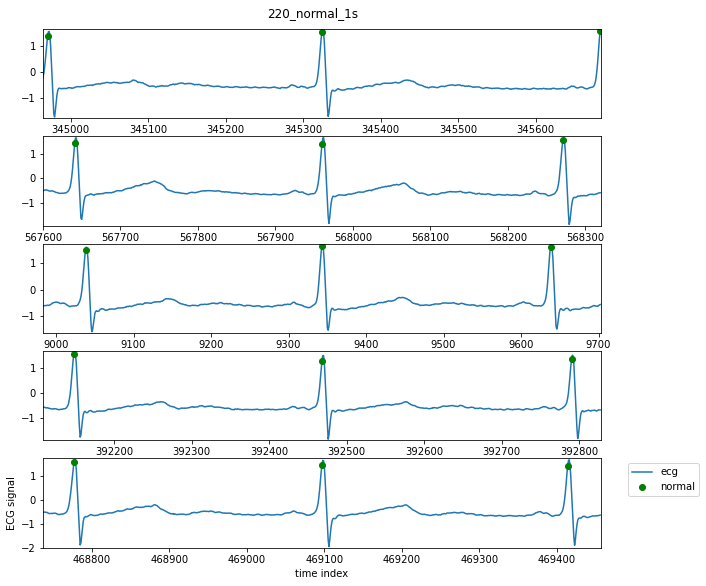

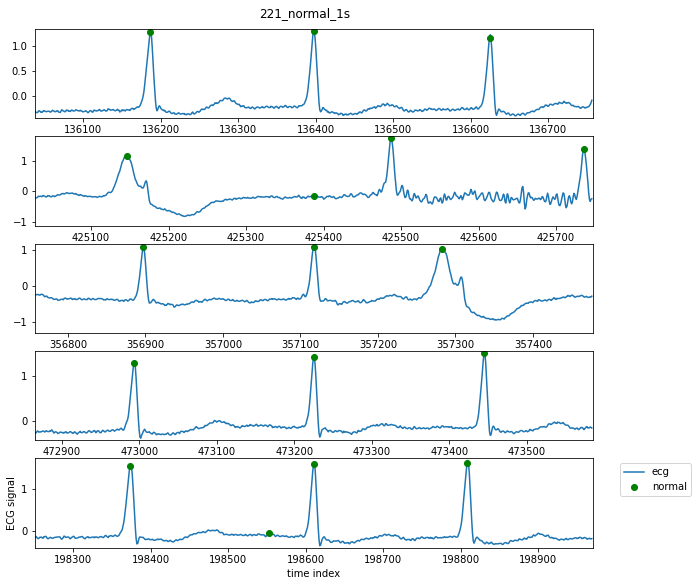

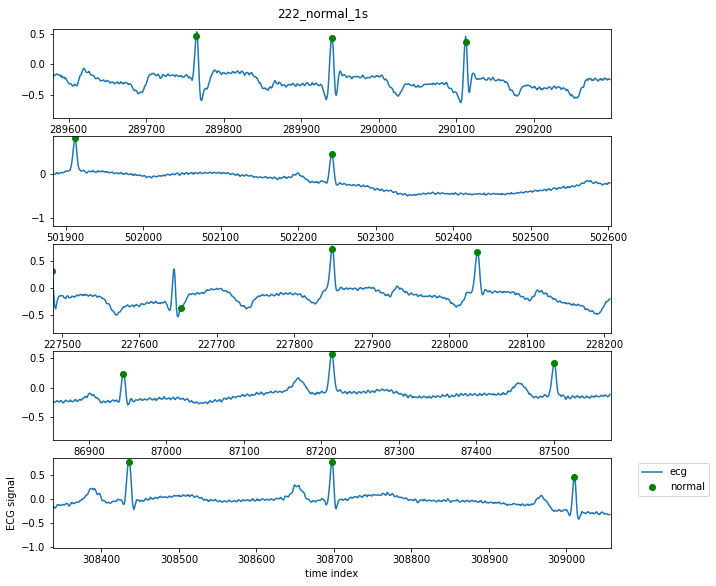

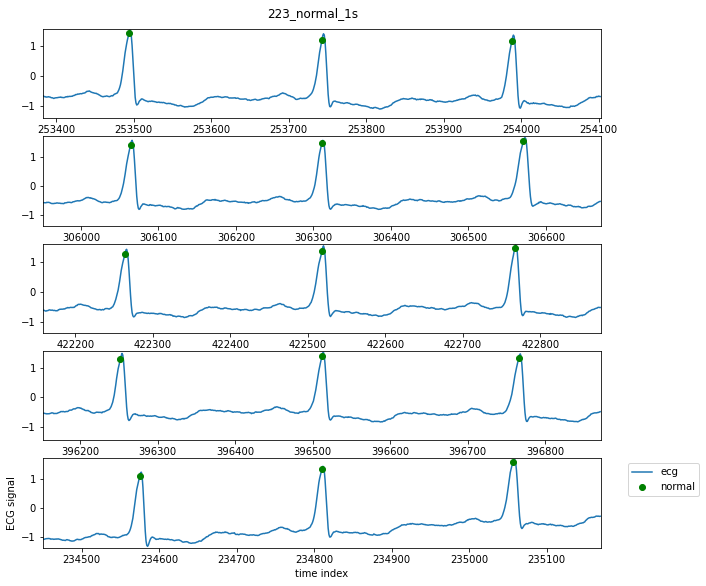

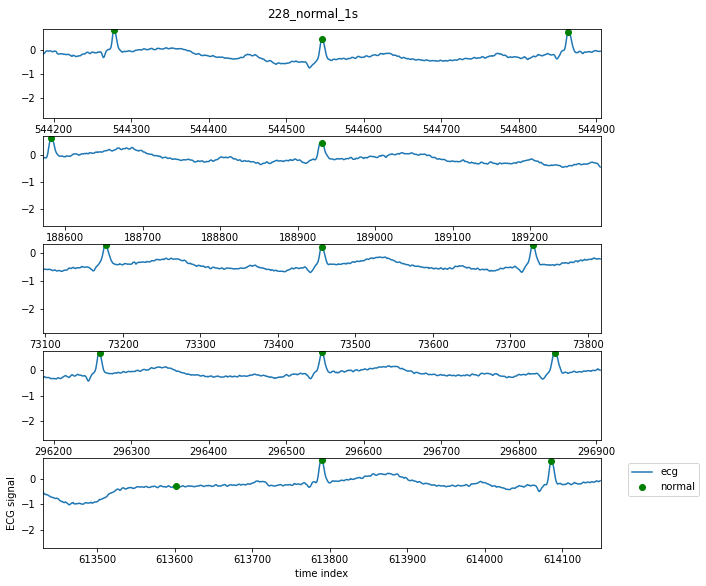

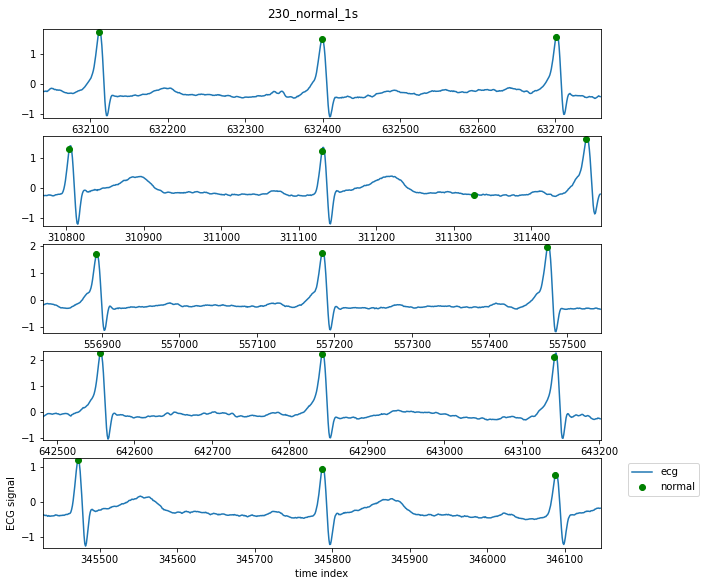

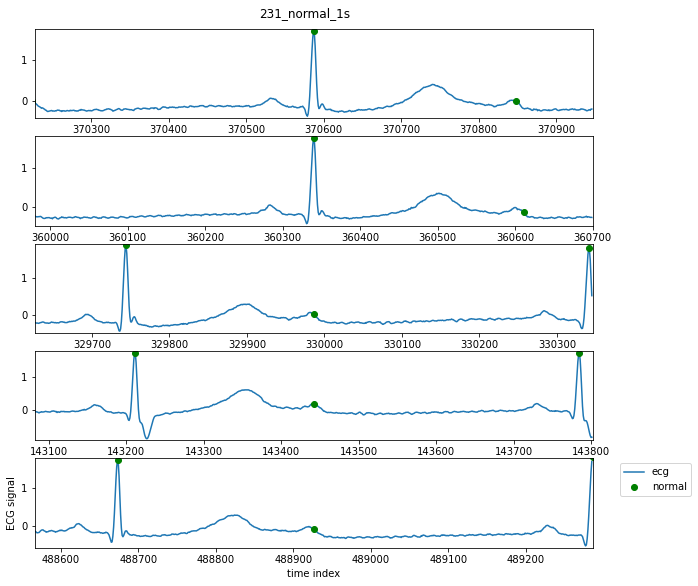

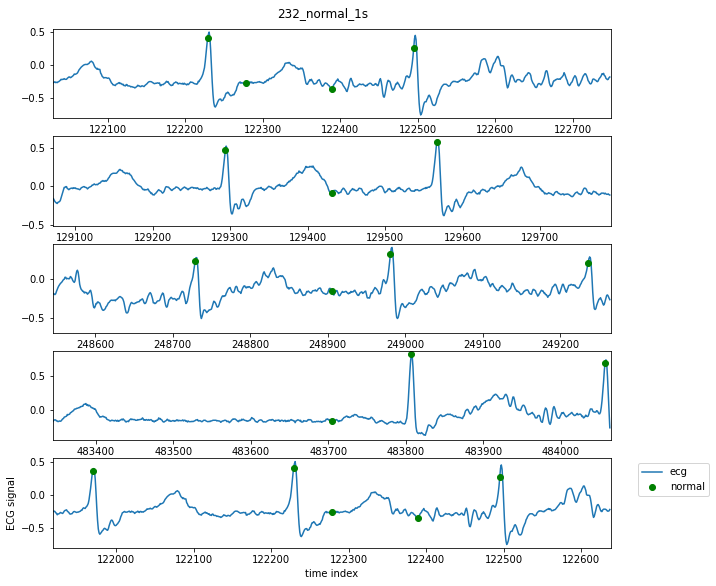

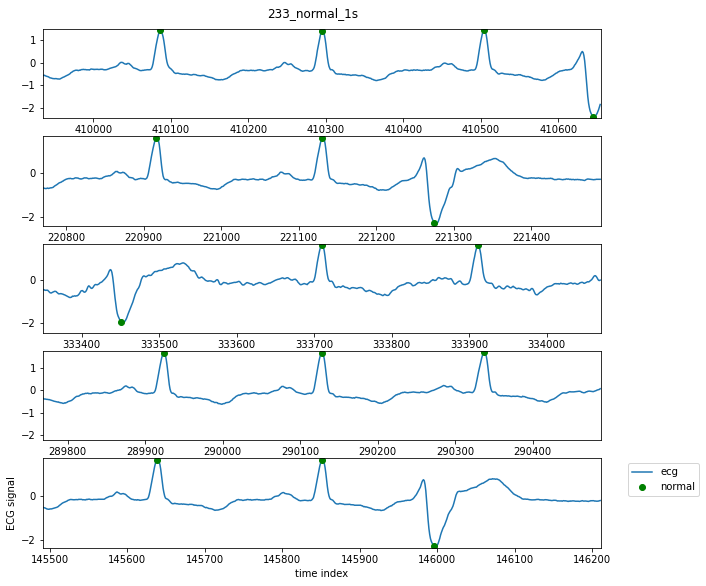

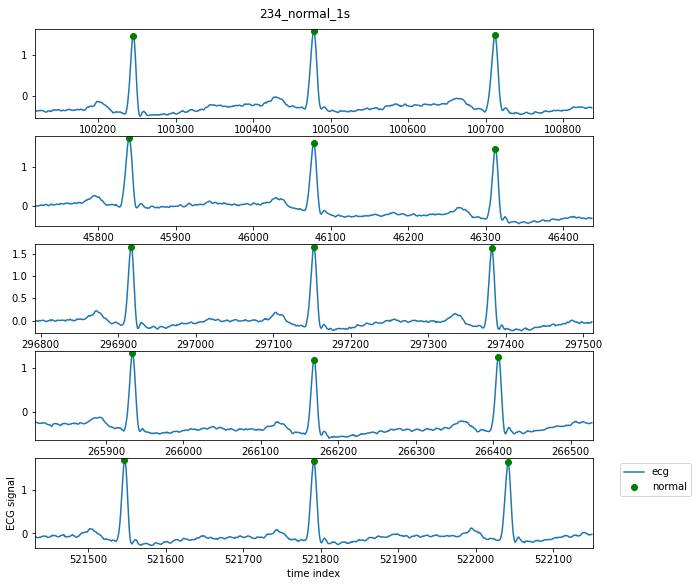

In [145]:
for i in range(len(pids)):
    ecg_plotting(pids[i], 1, 5, 'normal')

+ 1
A 33
N 2239
V 1
abnormal counts:  34 normal counts:  2240
[444705, 442623, 305709, 422818, 397335]
+ 1
A 3
N 1860
Q 2
| 4
~ 4
abnormal counts:  3 normal counts:  1871
[135299, 215567, 532014]
+ 5
/ 2028
N 99
V 4
f 56
abnormal counts:  2088 normal counts:  104
[95868, 100641, 113745, 304842, 69656]
+ 1
A 2
N 2082
~ 6
abnormal counts:  2 normal counts:  2089
[418275, 489639]
+ 45
/ 1380
N 163
Q 18
V 2
f 666
~ 37
abnormal counts:  2048 normal counts:  263
[536788, 535624, 180799, 357057, 500241]
+ 1
N 2526
Q 5
V 41
| 30
~ 88
abnormal counts:  41 normal counts:  2650
[296540, 74299, 126111, 12625, 118343]
+ 41
N 1507
V 520
~ 30
abnormal counts:  520 normal counts:  1578
[323673, 413724, 614694, 295133, 604958]
+ 1
/ 2078
V 59
~ 2
abnormal counts:  2137 normal counts:  3
[620074, 296594, 255838, 337542, 178483]
+ 1
A 4
F 2
N 1739
V 17
j 1
x 11
| 8
~ 41
abnormal counts:  24 normal counts:  1800
[490797, 526417, 107330, 435657, 631433]
+ 1
F 2
L 2492
V 38
~ 2
abnormal counts:  2532 normal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


+ 1
N 1953
| 6
~ 2
abnormal counts:  0 normal counts:  1962
[]
+ 1
A 1
N 2302
V 109
~ 8
abnormal counts:  110 normal counts:  2311
[558527, 550535, 302281, 181336, 624920]
+ 1
A 1
N 1534
~ 3
abnormal counts:  1 normal counts:  1538
[261541]
+ 1
A 96
R 2166
V 16
x 10
~ 12
abnormal counts:  2278 normal counts:  23
[137694, 606182, 433330, 641928, 537073]
+ 103
N 1543
V 444
~ 4
abnormal counts:  444 normal counts:  1650
[583617, 450193, 214821, 76131, 425470]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


+ 1
A 1
N 1861
V 1
~ 12
abnormal counts:  2 normal counts:  1874
[364260, 364922]
+ 1
N 2476
| 2
abnormal counts:  0 normal counts:  2479
[]
+ 1
N 1515
V 3
abnormal counts:  3 normal counts:  1516
[152471, 545876, 600047]
+ 13
A 2
F 5
J 29
R 1531
V 47
j 5
~ 2
abnormal counts:  1619 normal counts:  15
[238247, 629464, 106175, 425444, 18089]
+ 148
A 30
F 2
N 1743
V 826
~ 43
abnormal counts:  858 normal counts:  1934
[393656, 2506, 221367, 226356, 504603]
+ 35
A 30
F 2
J 1
N 1625
V 198
a 97
j 10
x 37
~ 4
abnormal counts:  338 normal counts:  1701
[385741, 468740, 441643, 523554, 383251]
+ 8
A 36
F 1
N 2061
V 19
a 19
| 2
abnormal counts:  75 normal counts:  2071
[482023, 407220, 422255, 419974, 278406]
+ 45
F 1
N 2529
Q 4
V 444
a 2
| 26
~ 57
abnormal counts:  447 normal counts:  2661
[123196, 26449, 129597, 553841, 135781]
+ 13
A 3
F 11
N 2571
V 71
| 1
~ 2
abnormal counts:  85 normal counts:  2587
[334162, 432140, 605645, 107977, 353821]
! 472
+ 24
A 107
E 105
L 1457
R 86
V 105
[ 6
] 6
| 2

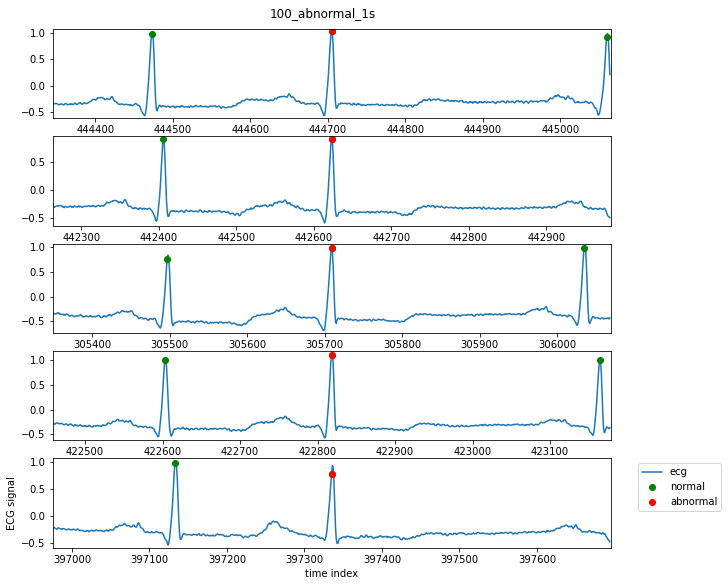

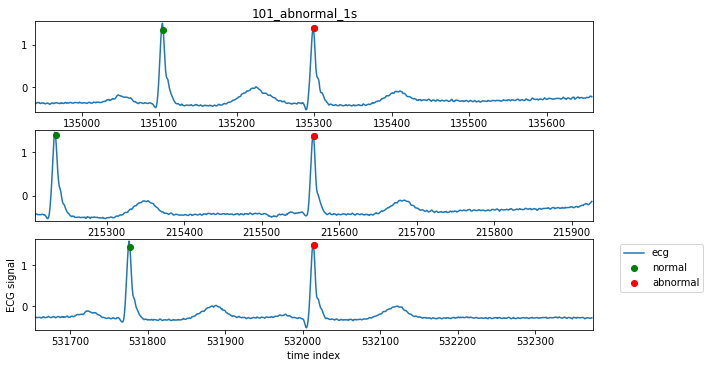

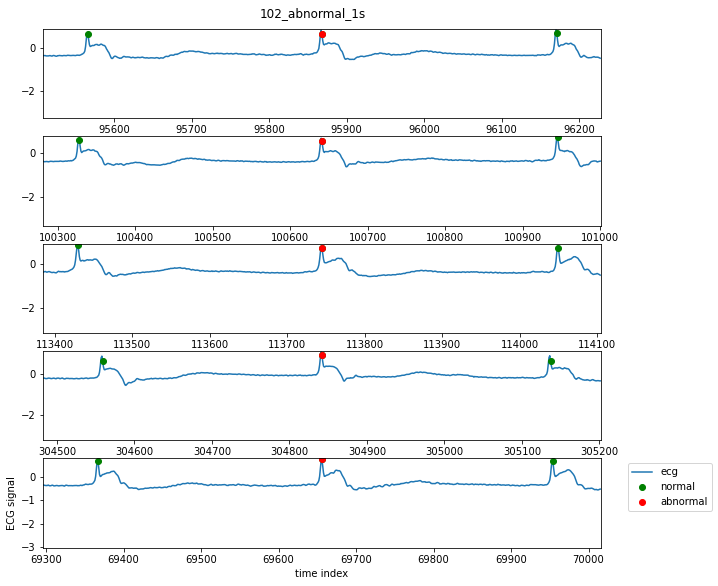

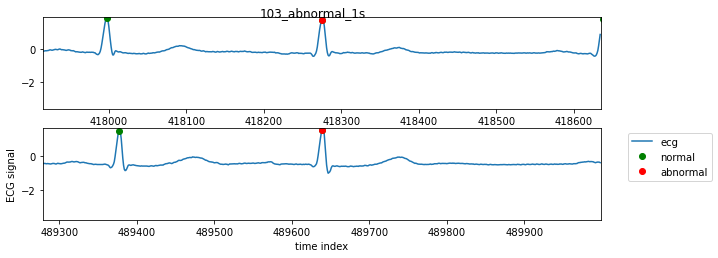

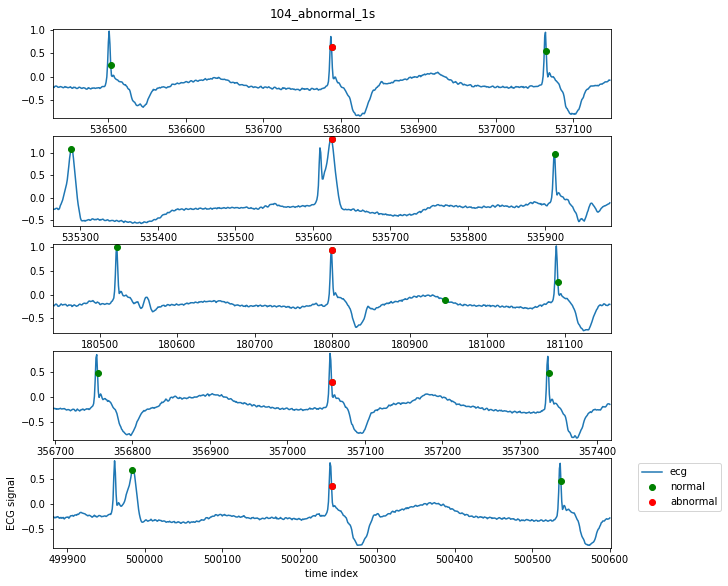

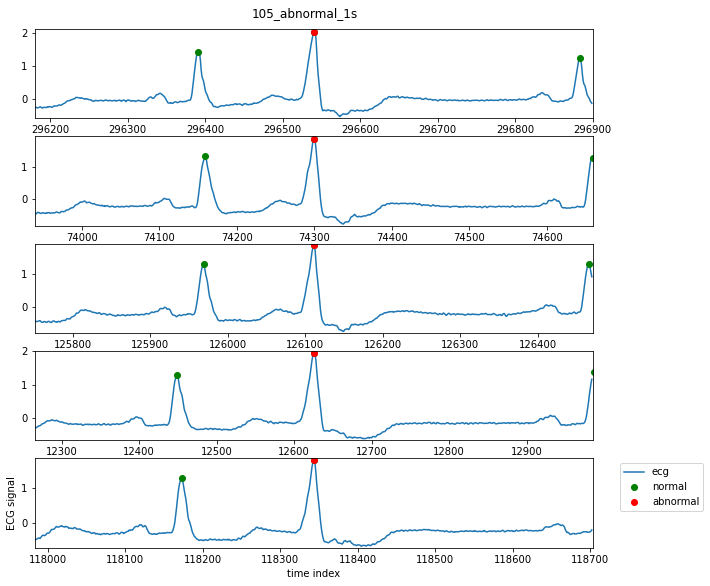

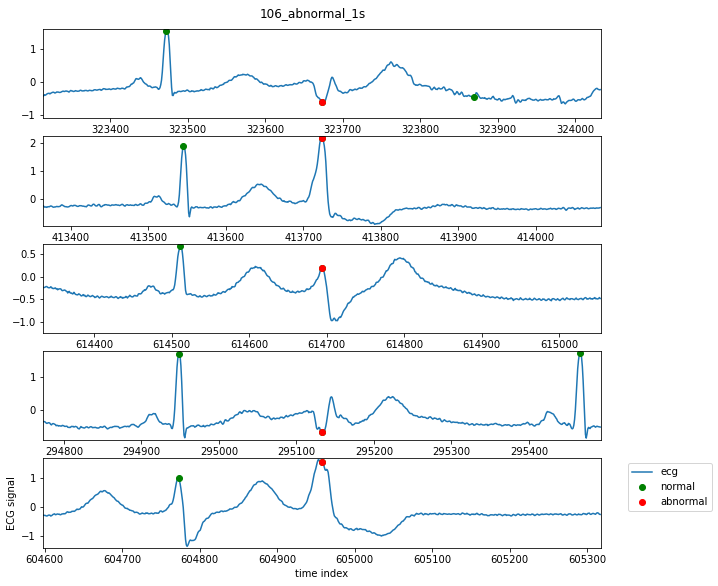

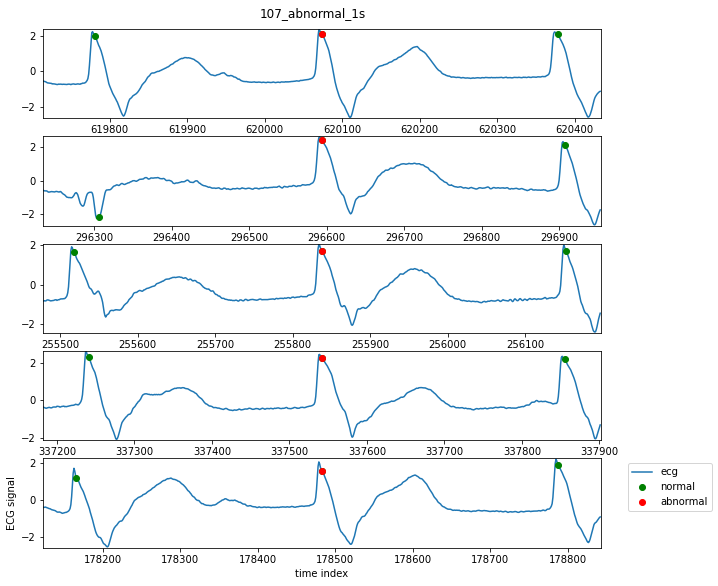

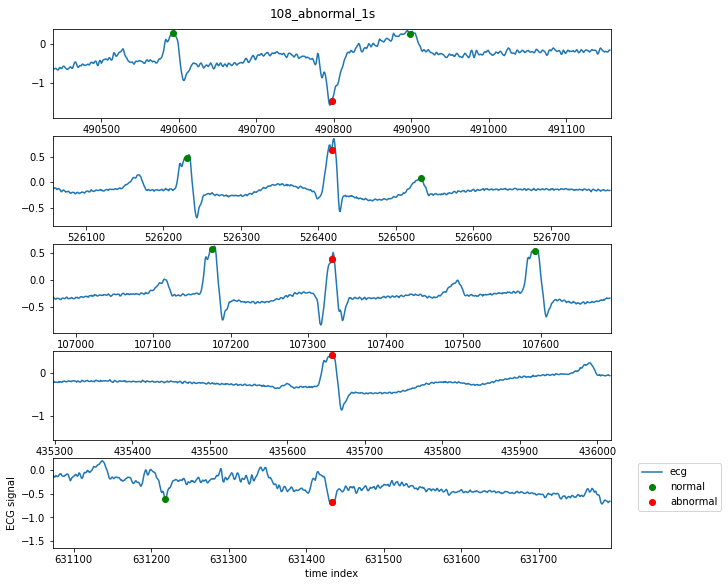

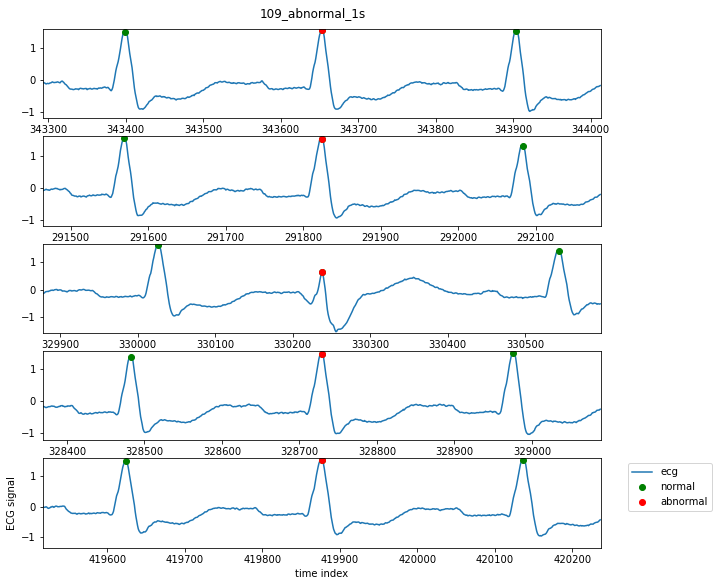

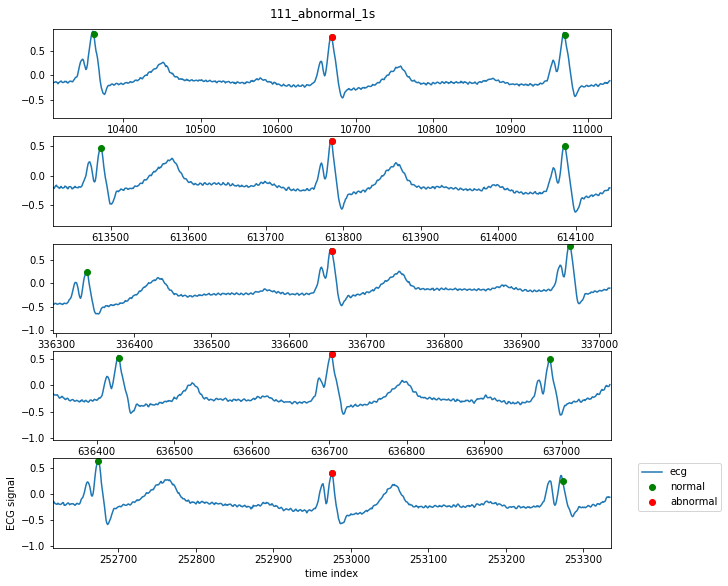

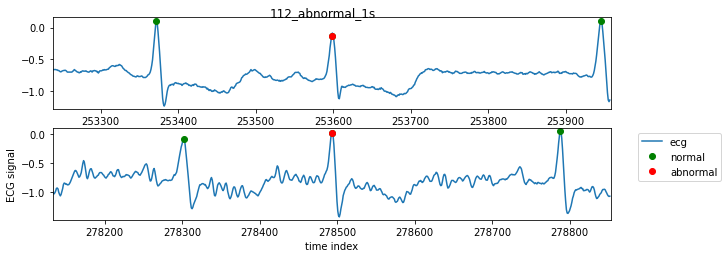

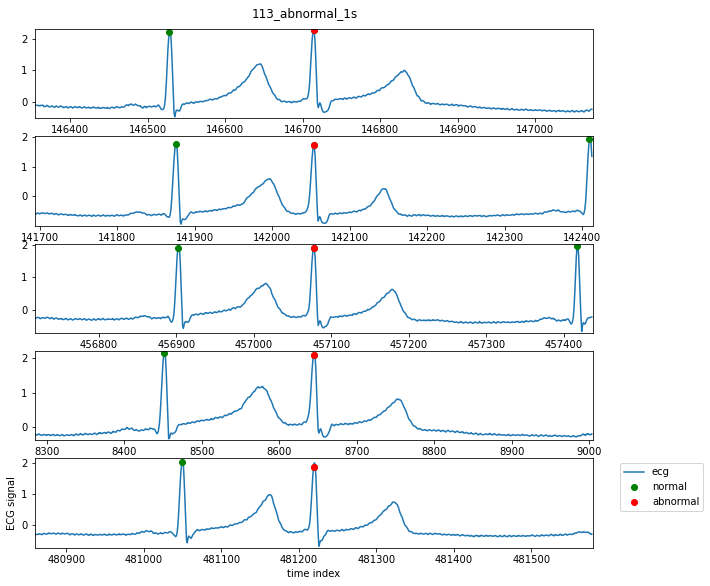

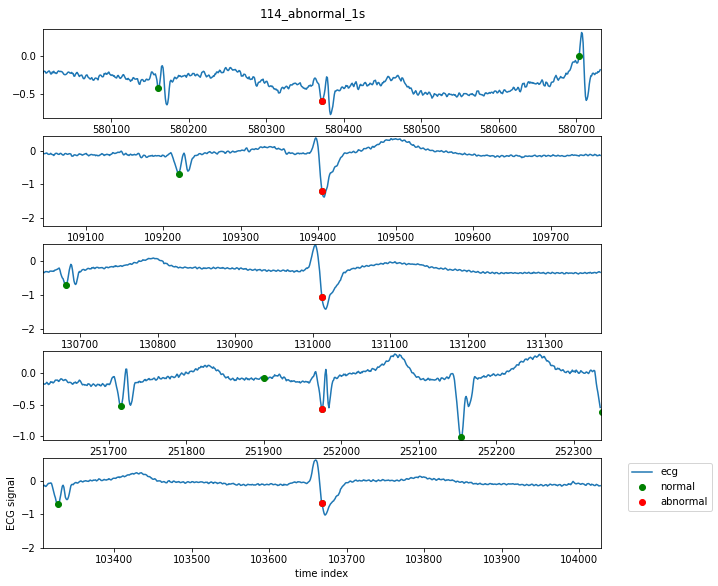

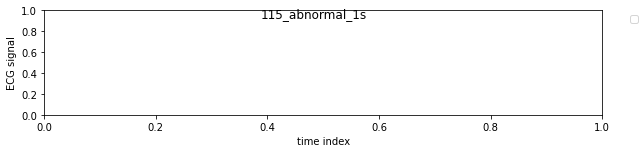

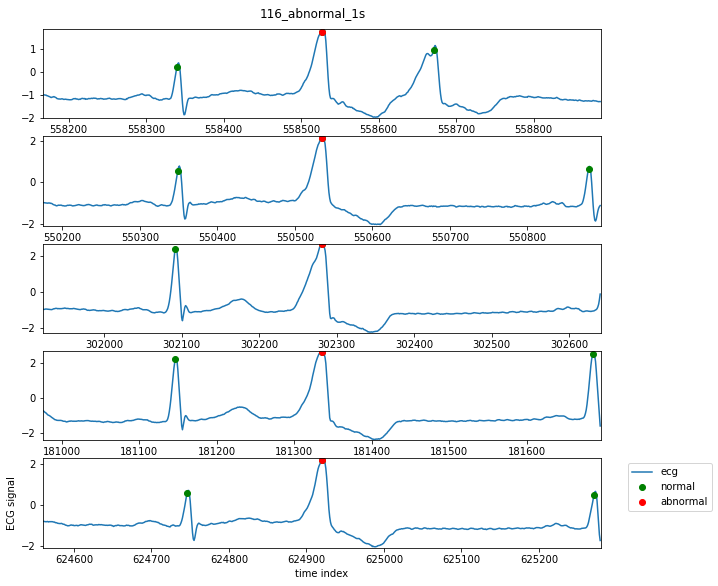

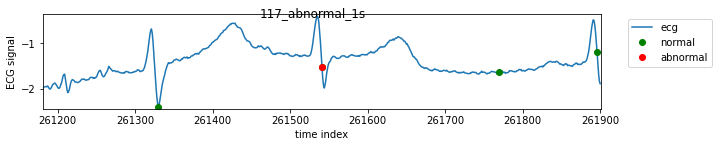

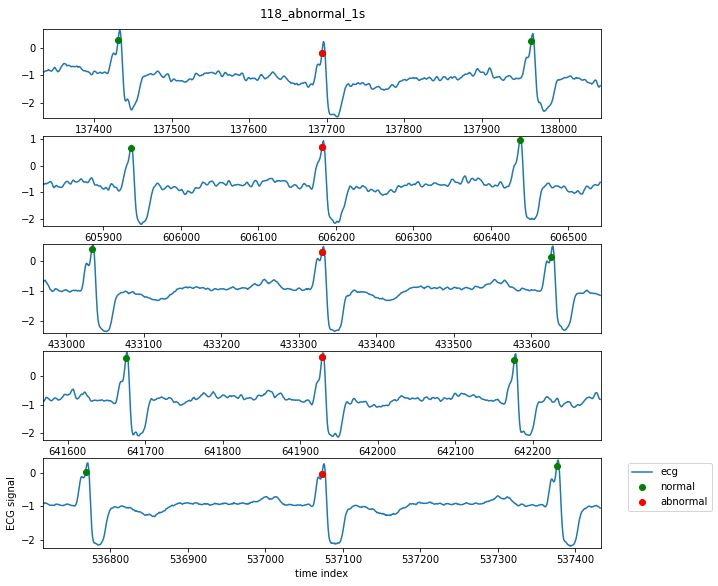

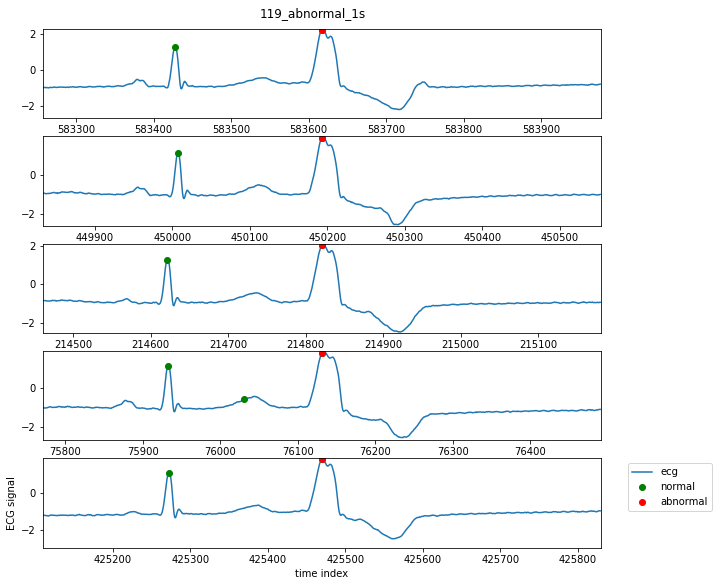

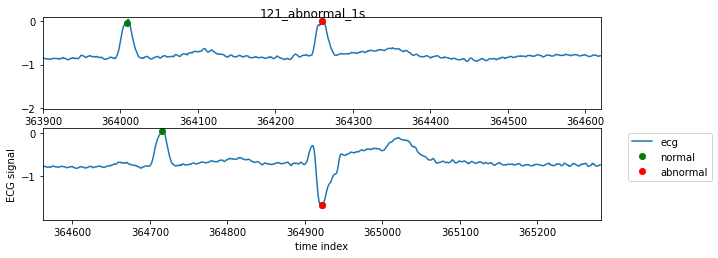

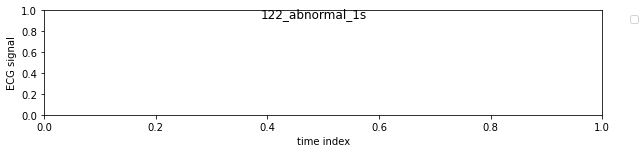

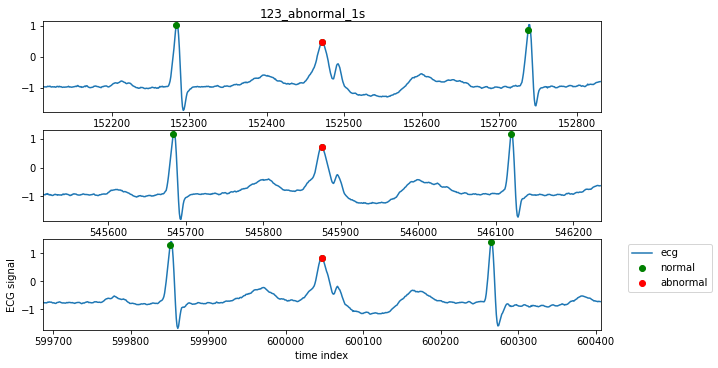

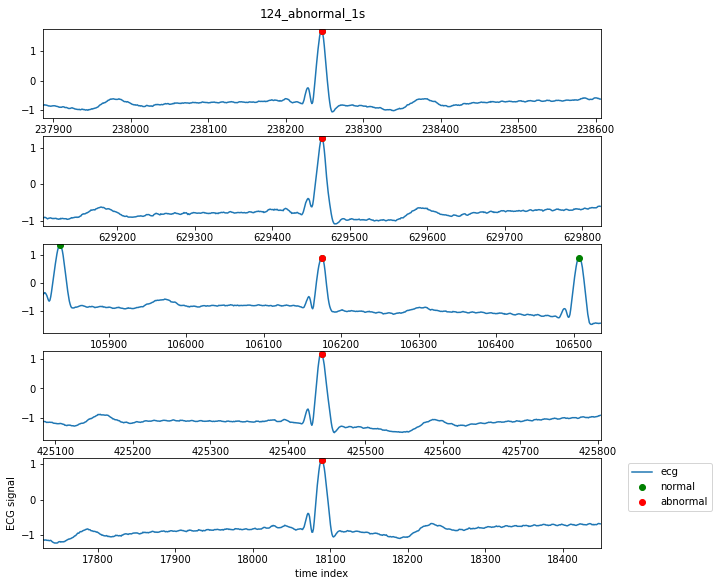

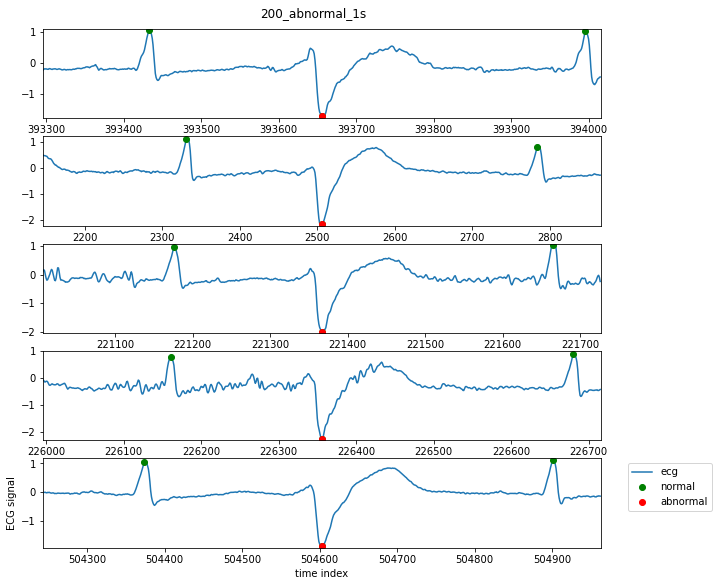

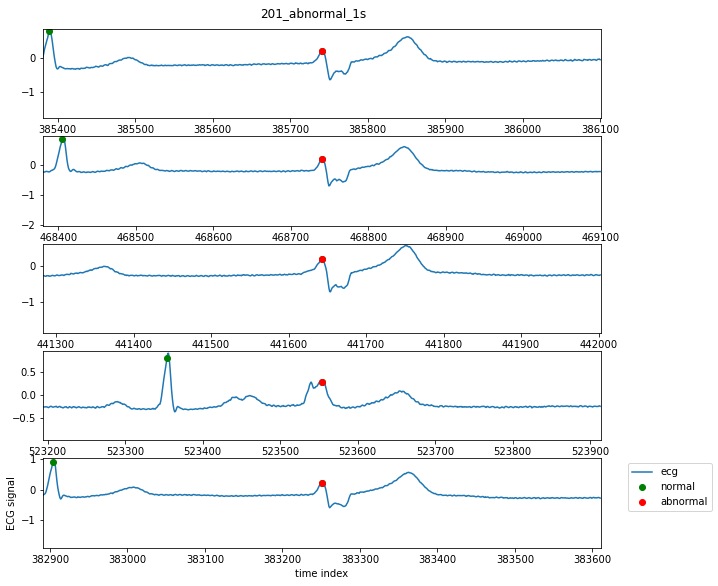

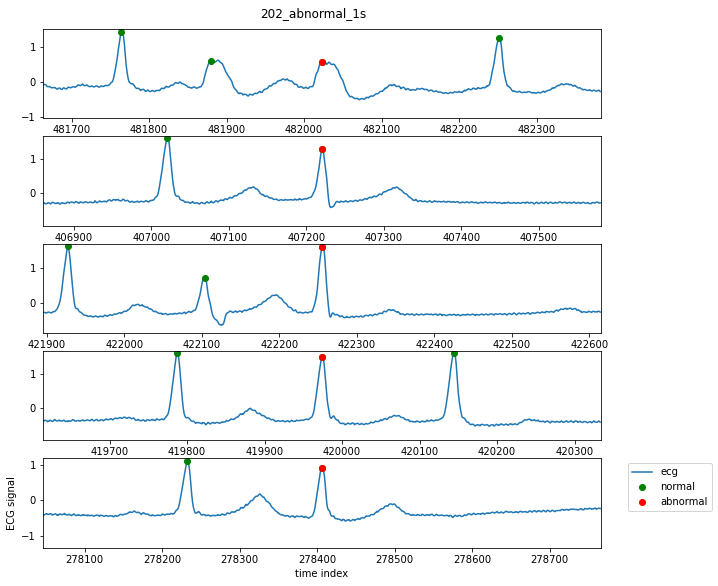

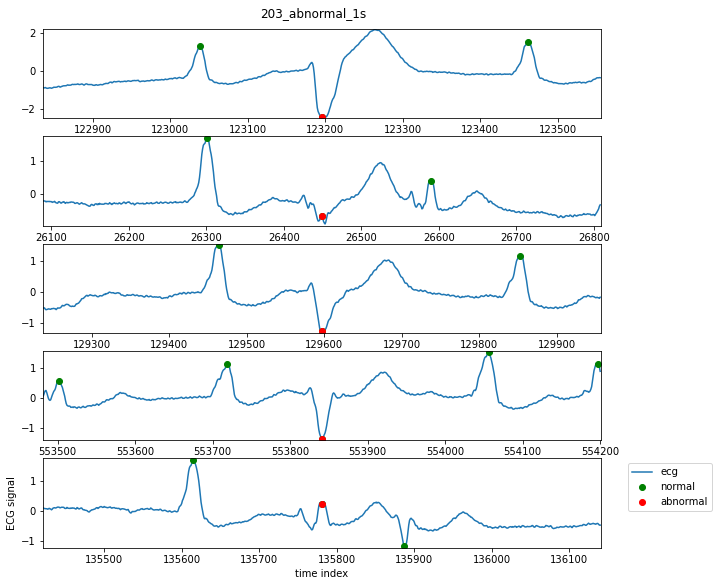

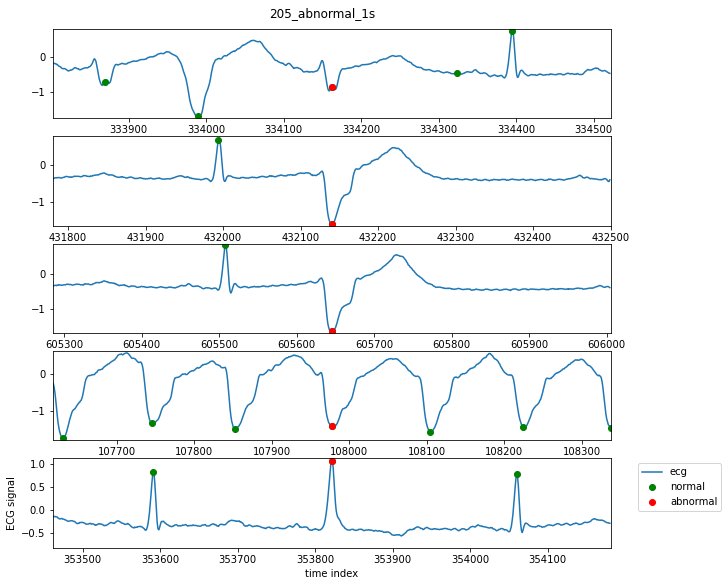

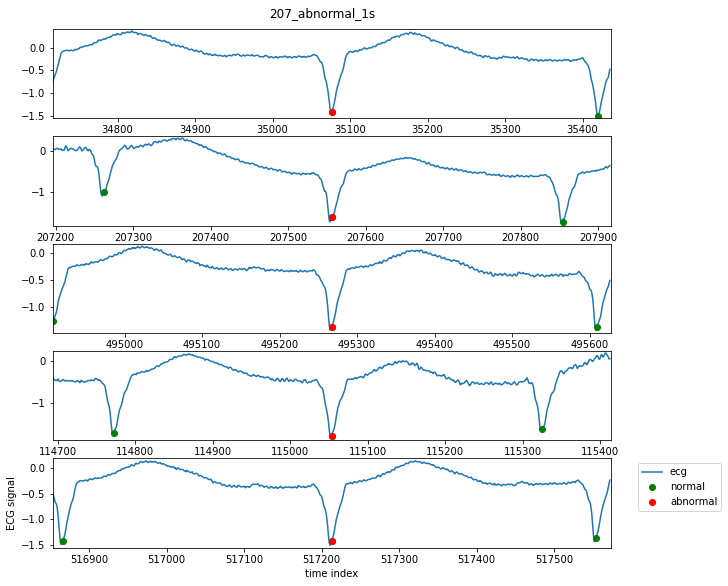

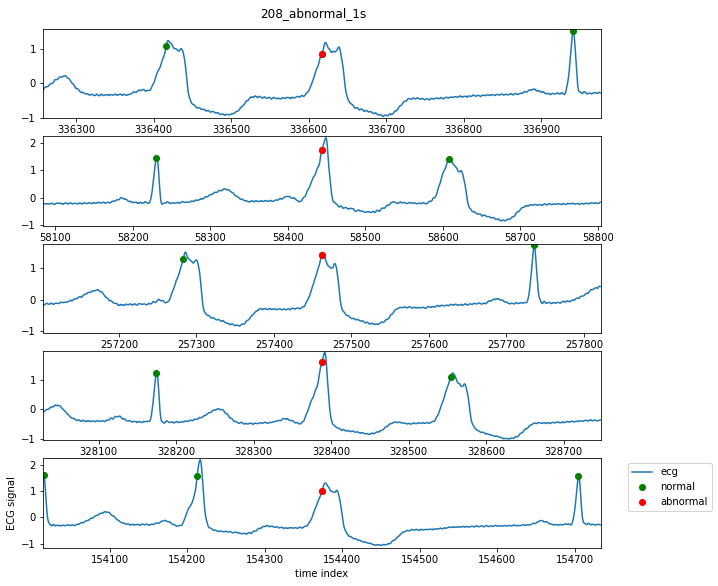

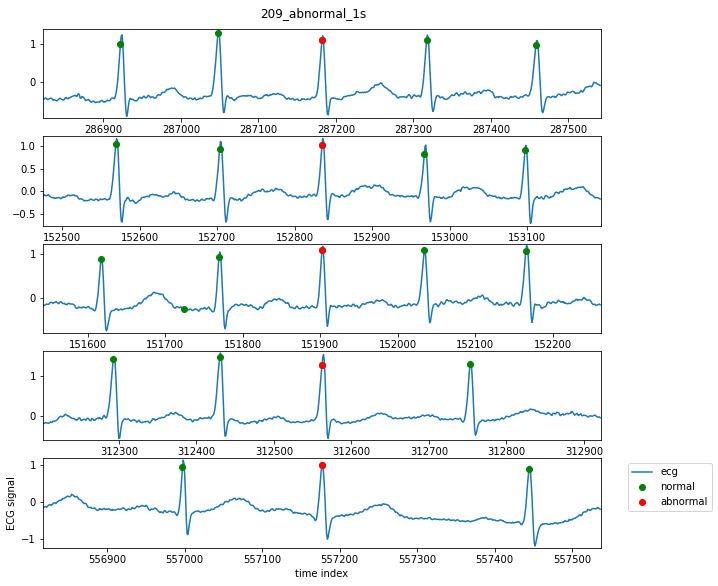

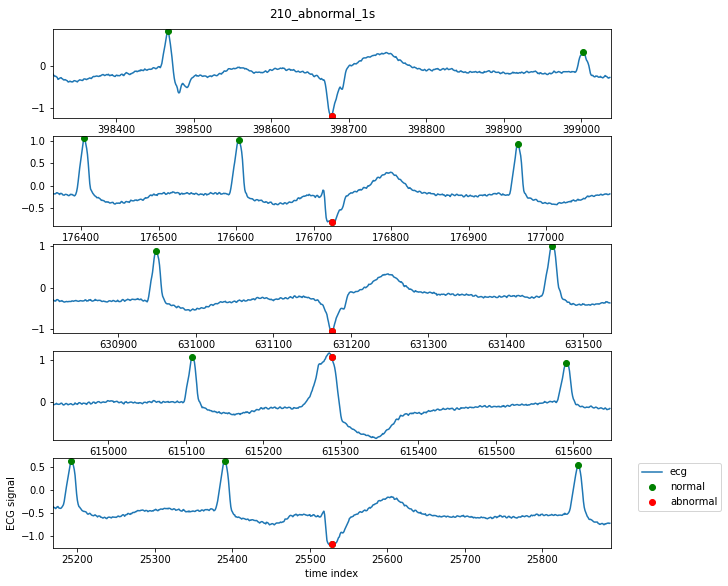

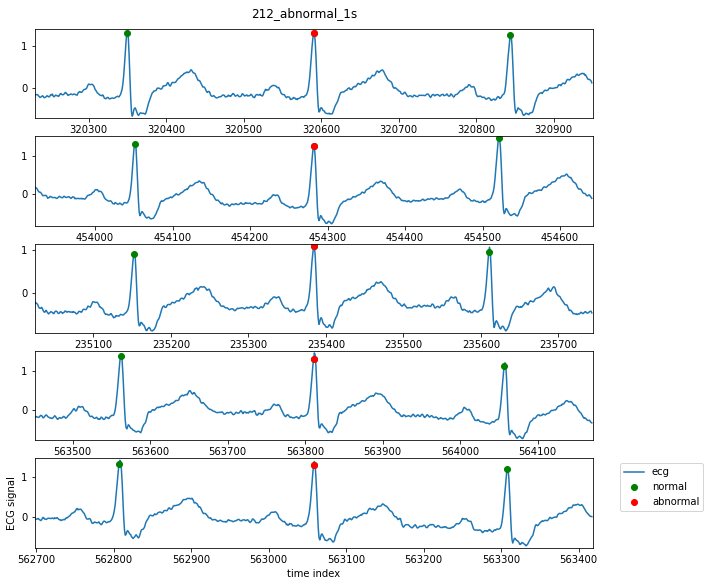

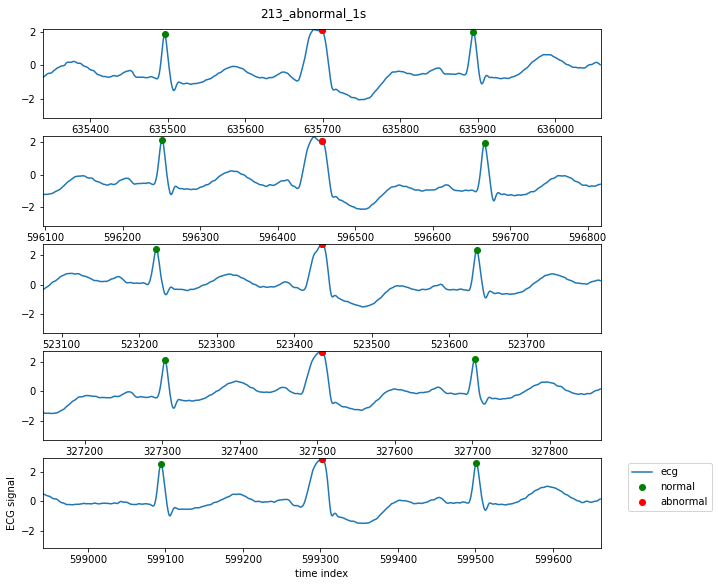

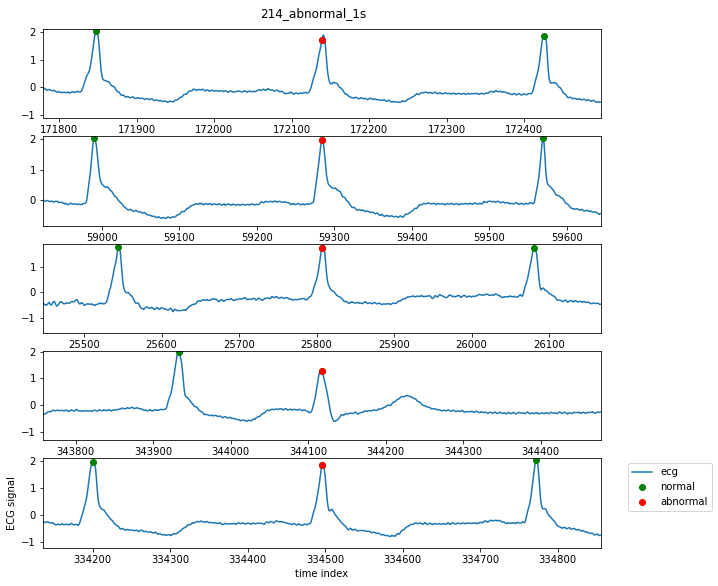

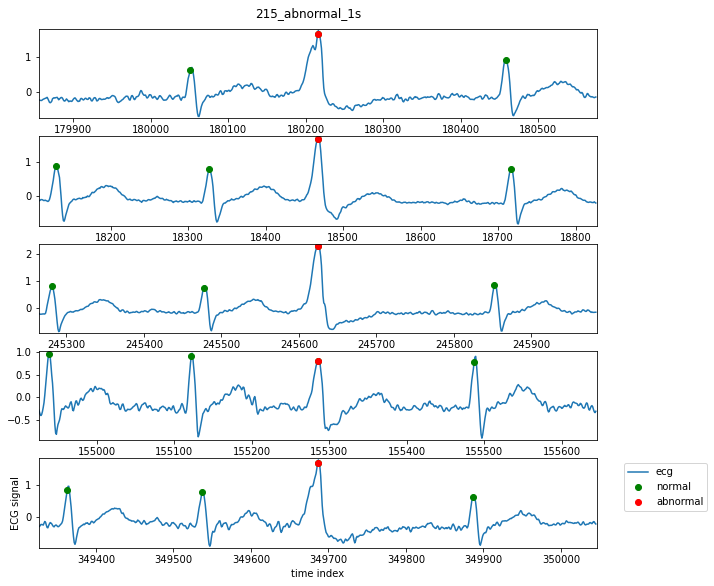

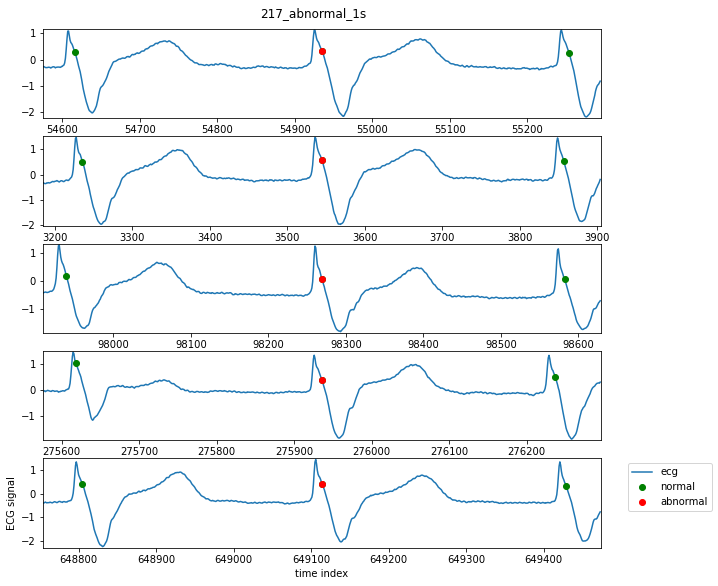

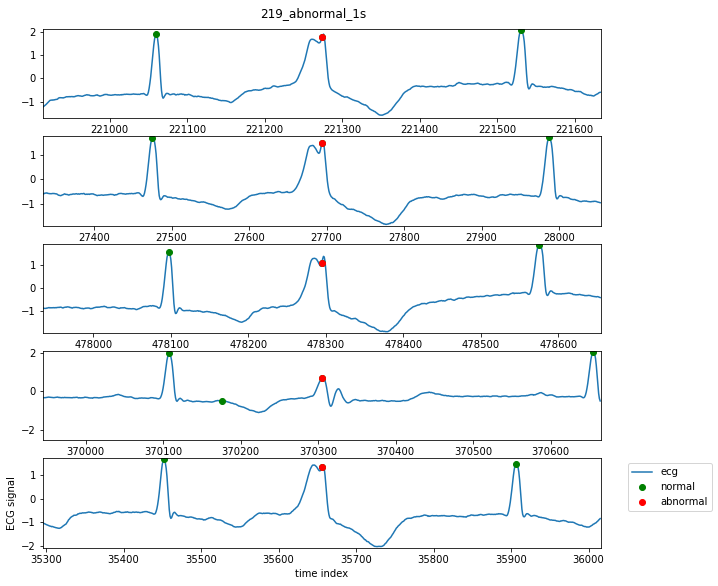

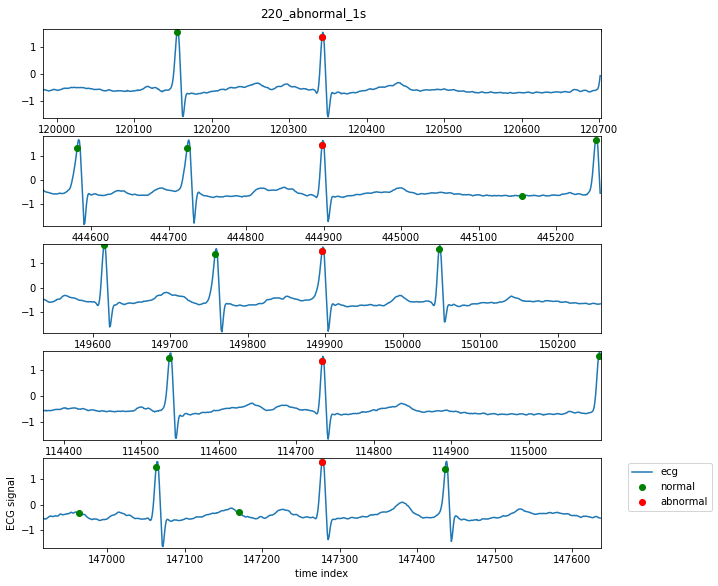

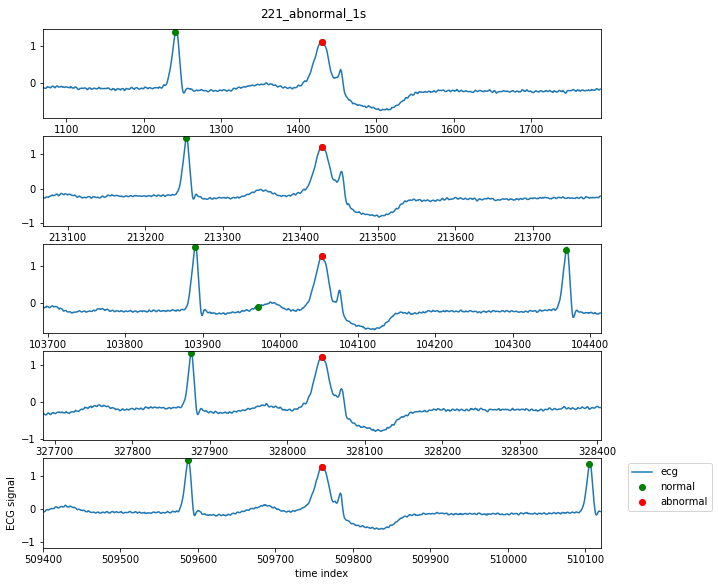

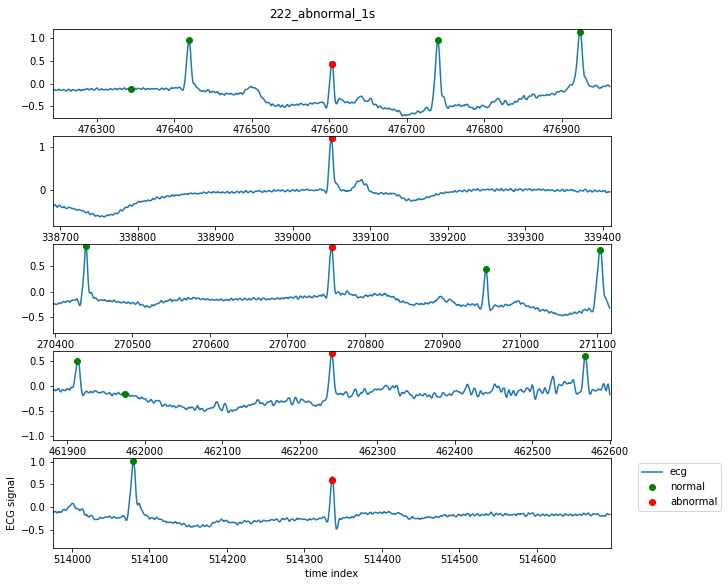

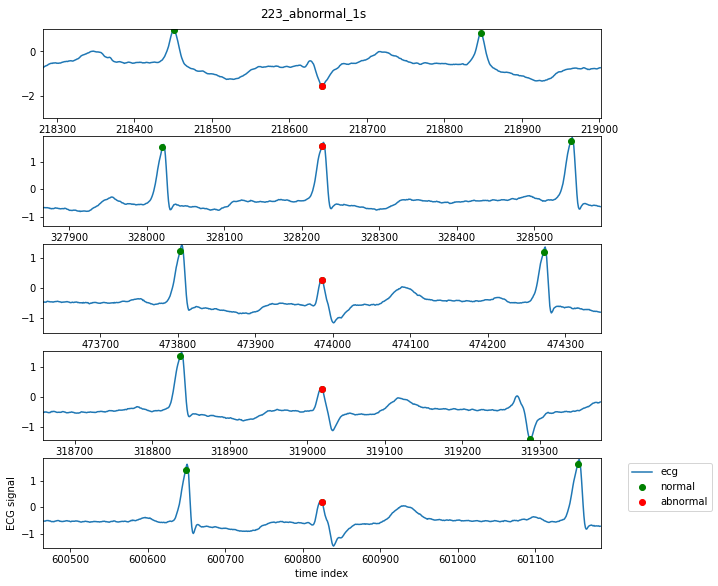

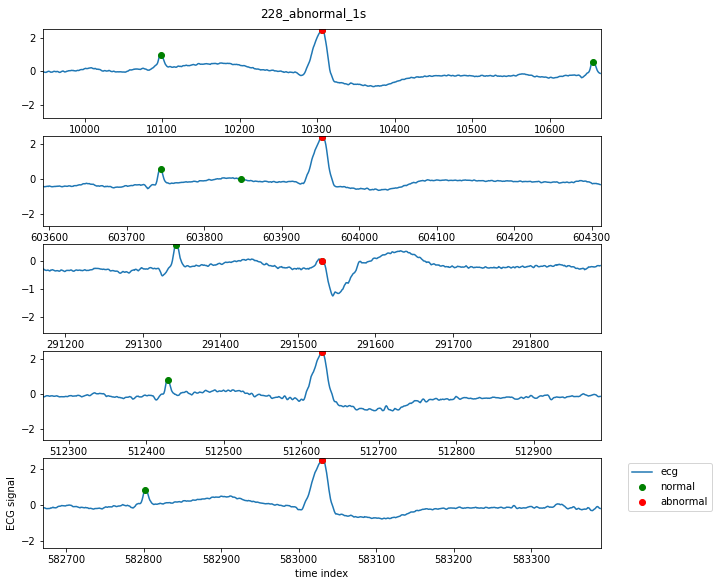

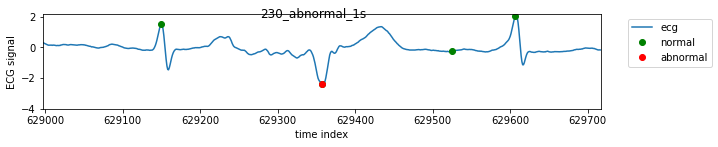

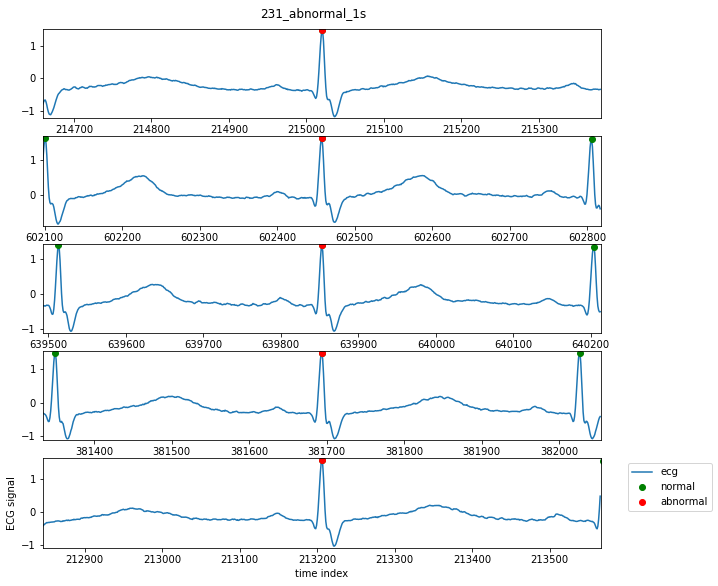

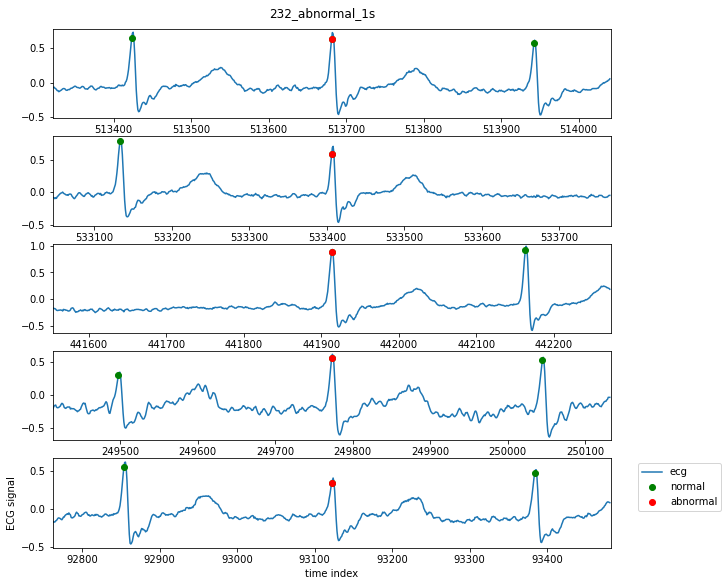

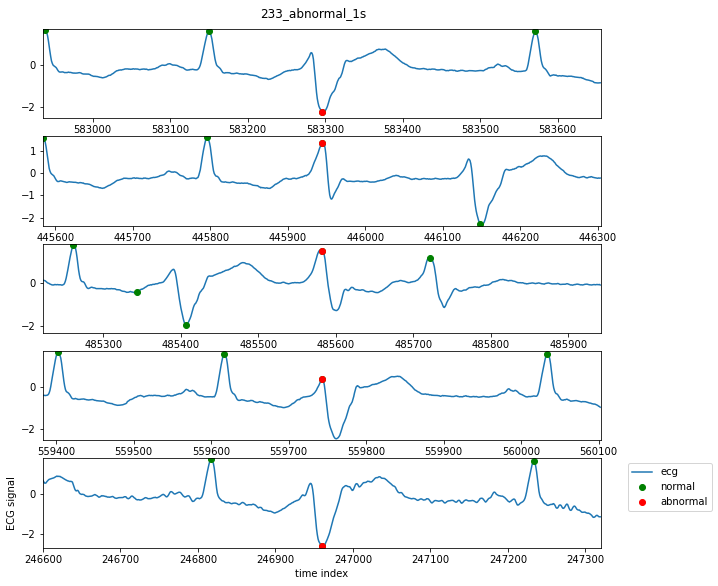

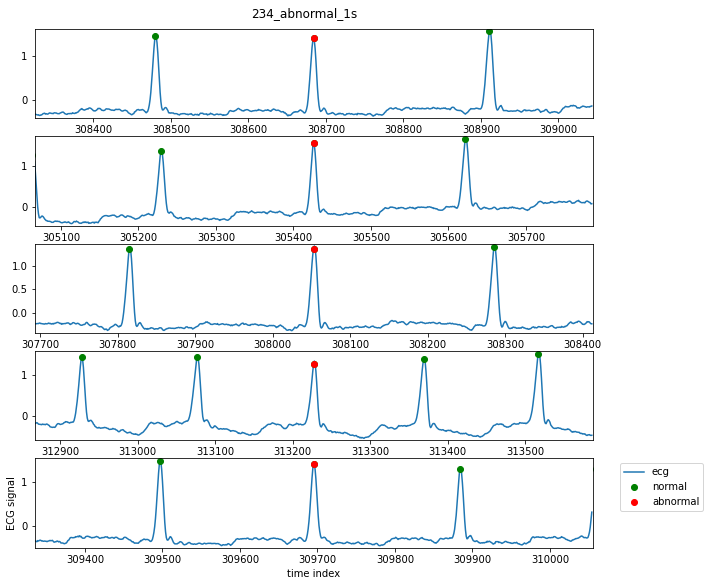

In [146]:
for i in range(len(pids)):
    ecg_plotting(pids[i], 1, 5, 'abnormal')

---

In [191]:
# def ecg_plotting2(pid, sec, randsample, ecg_type):
    
#     file = os.path.join(datapath, pid) #pid=pids[0]
#     fig_ = pid + '_' + ecg_type + '_' + str(sec) + 's' # + '.jpg'
#     p_signal, atr_sym, atr_sample = load_ecg(file)
    
#     values, counts = np.unique(atr_sym, return_counts = True)
#     for v, c in zip(values, counts):
#         print(v, c)
        
#     ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal]
#     n_index =  [b for a,b in zip(atr_sym,atr_sample) if not a in abnormal]
#     # ab_index, n_index
#     print('abnormal counts: ', len(ab_index), 'normal counts: ', len(n_index))
    
#     if ecg_type == 'abnormal':
#         tmp_index = ab_index
    
#     else:
#         tmp_index = n_index   
        
#     if randsample < len(tmp_index): 
#         # tmp_index = random.sample(tmp_index, randsample)    
#         yplt = randsample+1 
#     else:
#         yplt = len(tmp_index)+1
    
#     print(tmp_index)
    

#     x = np.arange(len(p_signal))
#     fig = plt.figure(figsize=(10, yplt*2))
#     # fig = plt.gcf()
#     #, fontsize=14)
#     st = fig.suptitle(fig_)    
       
#     for i in range(1,(len(tmp_index)+1)):
#         atr_sample 
#         try:
#             left = tmp_index[i-1]-(360*sec) # 전 sec 초
#             right = tmp_index[i-1]+(360*sec) # 후 sec 초

#             plt.subplot(yplt,1, i)

#             plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
#             plt.plot(x[n_index],p_signal[n_index,0],'go',label ='normal')
#             plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

#             plt.xlim(left,right)
#             plt.ylim(p_sxignal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
            
#         except:
#             left = tmp_index[i-1]-(360*sec) # 전 sec 초
#             right = tmp_index[i-1]+(360*sec) # 후 sec 초

#             plt.subplot(yplt,1, i)

#             plt.plot(x[0:right],p_signal[0:right, 0], '-', label='ecg')
#             plt.plot(x[n_index],p_signal[n_index,0],'go',label ='normal')
#             plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

#             plt.xlim(0,right)
#             plt.ylim(p_signal[0:right].min()-0.05,p_signal[0:right,0].max()+0.05)

   
#     plt.xlabel('time index')
#     plt.ylabel('ECG signal')    
#     # plt.title(ecg_type)#, ' plots')
#     plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
#     st.set_y(0.88)
#     fig.subplots_adjust(top=0.85)
#     fig.savefig(os.path.join(r'C:\Users\cogreen\Projects\signal\fig2', ecg_type, fig_ +'.jpg'))

----

In [17]:
def rand_set(pid, randsample, ecg_type):
    
    file = os.path.join(datapath, pid) #pid=pids[0]
    p_signal, atr_sym, atr_sample = load_ecg(file)
    
    values, counts = np.unique(atr_sym, return_counts = True)
    for v, c in zip(values, counts):
        print(v, c)
        
    ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal]
    n_index =  [b for a,b in zip(atr_sym,atr_sample) if not a in abnormal]
    # ab_index, n_index
    print('abnormal counts: ', len(ab_index), 'normal counts: ', len(n_index))
    
    if ecg_type == 'abnormal':
        tmp_index = ab_index
    
    else:
        tmp_index = n_index   
        
    if randsample < len(tmp_index): 
        tmp_index = random.sample(tmp_index, randsample)    
        yplt = randsample+1 
    else:
        yplt = len(tmp_index)+1
    
    return tmp_index, yplt, ab_index, n_index, p_signal, atr_sym, atr_sample

In [25]:
def ecg_plotting3(pid, sec, ecg_type):

    fig_ = pid + '_' + ecg_type + '_' + str(sec) + 's' # + '.jpg'
    x = np.arange(len(p_signal))
    fig = plt.figure(figsize=(10, yplt*2))
    # fig = plt.gcf()
    #, fontsize=14)
    st = fig.suptitle(fig_)    
       
    for i in range(1,(len(tmp_index)+1)):
        atr_sample 
        try:
            left = tmp_index[i-1]-(360*sec) # 전 sec 초
            right = tmp_index[i-1]+(360*sec) # 후 sec 초

            plt.subplot(yplt,1, i)

            plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
            plt.plot(x[n_index],p_signal[n_index,0],'go',label ='normal')
            plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

            plt.xlim(left,right)
            plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
            
        except:
            left = tmp_index[i-1]-(360*sec) # 전 sec 초
            right = tmp_index[i-1]+(360*sec) # 후 sec 초

            plt.subplot(yplt,1, i)

            plt.plot(x[0:right],p_signal[0:right, 0], '-', label='ecg')
            plt.plot(x[n_index],p_signal[n_index,0],'go',label ='normal')
            plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

            plt.xlim(0,right)
            plt.ylim(p_signal[0:right].min()-0.05,p_signal[0:right,0].max()+0.05)

   
    plt.xlabel('time index')
    plt.ylabel('ECG signal')    
    # plt.title(ecg_type)#, ' plots')
    plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
    st.set_y(0.88)
    fig.subplots_adjust(top=0.85)
    time.sleep(1)
    fig.savefig(os.path.join(r'C:\Users\MI2RL-KHJ\2022_Project\Signal\fig', ecg_type, fig_ +'.jpg'))


+ 1
A 33
N 2239
V 1
abnormal counts:  34 normal counts:  2240


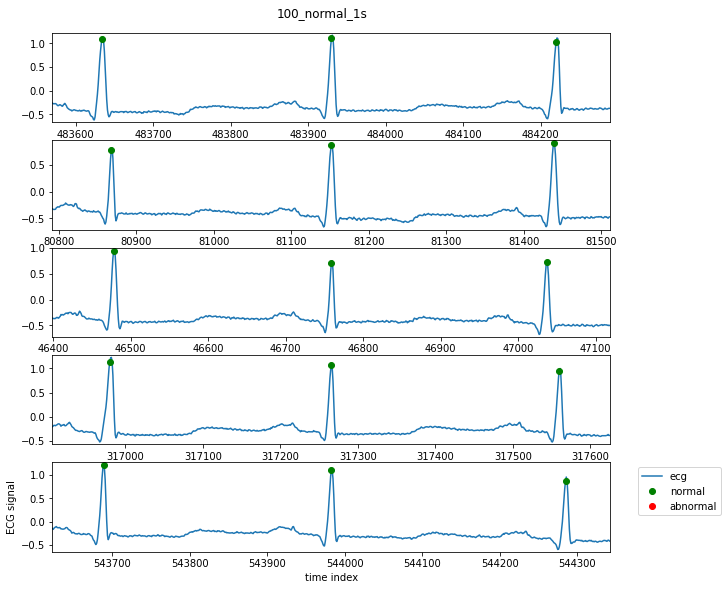

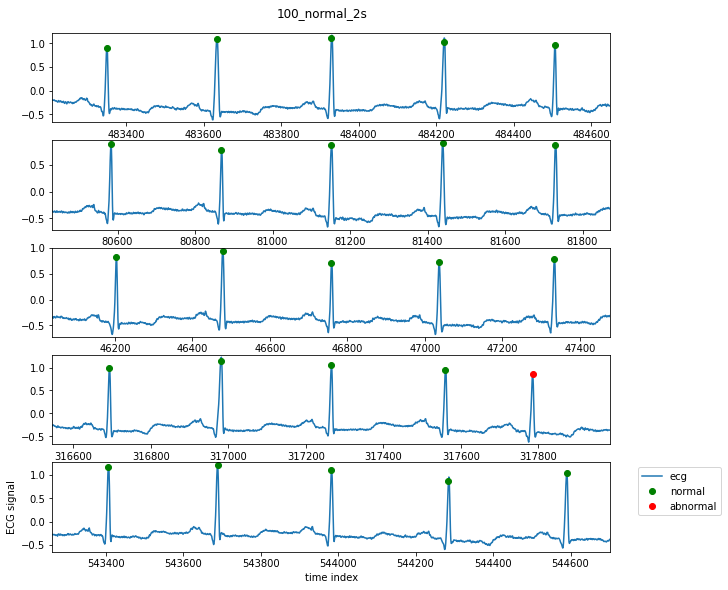

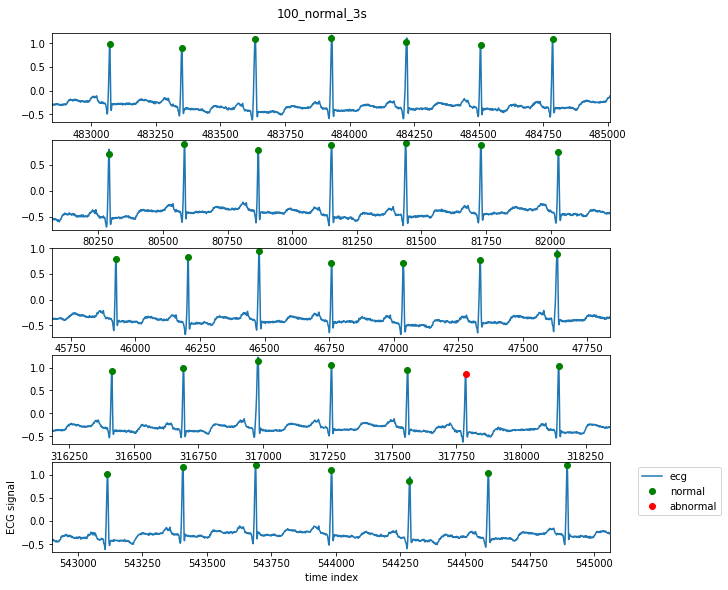

In [24]:
for i in range(len(pids)):
    tmp_index, yplt, ab_index, n_index, p_signal, atr_sym, atr_sample = rand_set(pids[i], 5, 'normal')
    
    ecg_plotting3(pids[i], 1, 'normal')
    ecg_plotting3(pids[i], 2, 'normal')
    ecg_plotting3(pids[i], 3, 'normal')
    break

+ 1
A 33
N 2239
V 1
abnormal counts:  34 normal counts:  2240


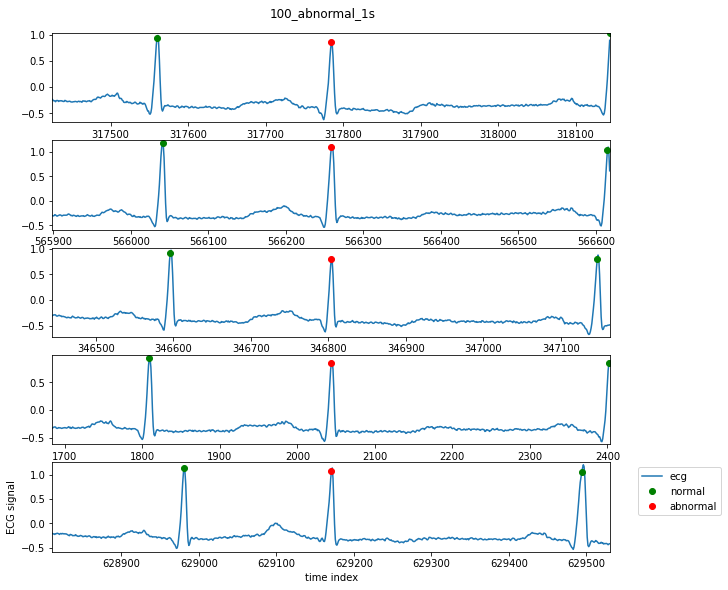

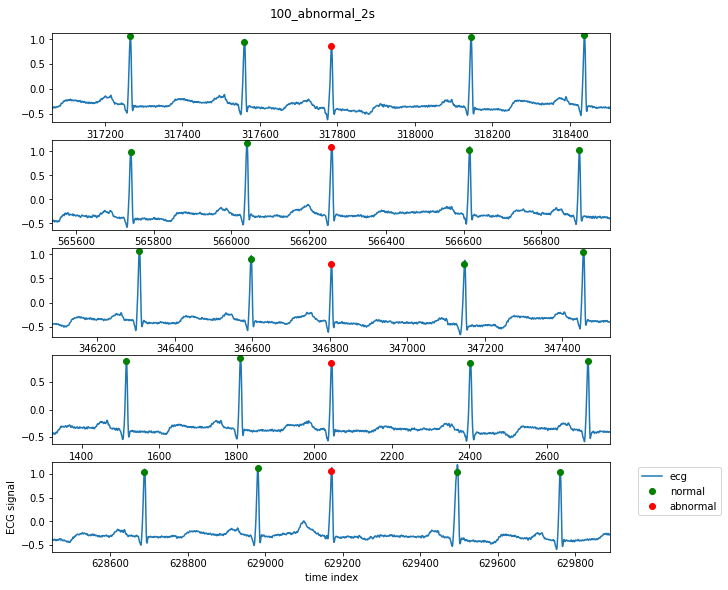

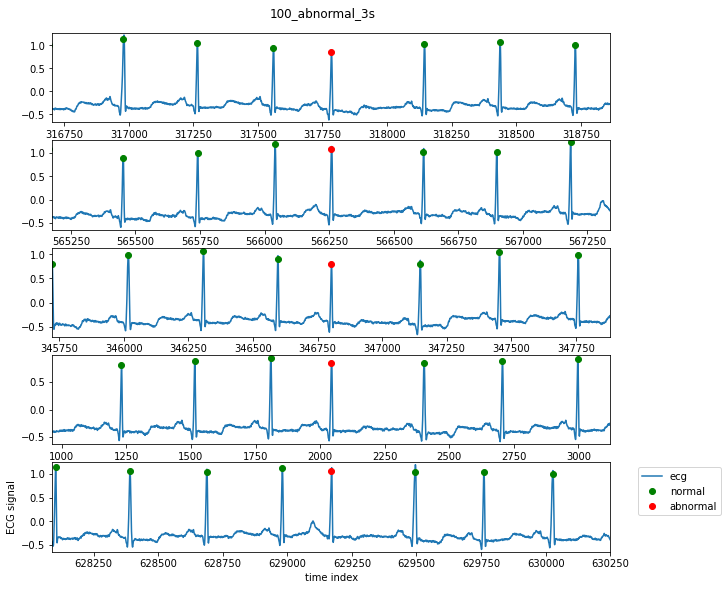

In [26]:
for i in range(len(pids)):
    tmp_index, yplt, ab_index, n_index, p_signal, atr_sym, atr_sample = rand_set(pids[i], 5, 'abnormal')
    
    ecg_plotting3(pids[i], 1, 'abnormal')
    ecg_plotting3(pids[i], 2, 'abnormal')
    ecg_plotting3(pids[i], 3, 'abnormal')
    break

----

## 3. Preparing dataset for deep learning

#### 3-1. Define functions to build dataset for deep learning

In [27]:
def build_dataset(pids, window_size, freq, abnormal):
    """
    딥러닝 모델 학습을 위한 데이터를 구축합니다.
    """
    ncols = window_size * freq
    X_merged = np.zeros((1, ncols))
    Y_merged = np.zeros((1,1))
    symbol_merged = []
    
    rows_per_pid = []
    
    for pid in tqdm.tqdm(pids):
        
        filename = os.path.join(datapath, pid)
        p_signal, atr_sym, atr_sample = load_ecg(filename)
        
        p_signal = p_signal[:,0]
        
        # beat index (exclude non-beat)
        beat_annotation_index = [x in (abnormal + ['N']) for x in atr_sym]
        
        X, Y, symbols = build_XY(signal=p_signal, 
                                 atr_sym = atr_sym, 
                                 atr_sample = atr_sample,
                                 beat_index = beat_annotation_index, 
                                 nsec = window_size/2, 
                                 fs = freq,
                                 ncols = ncols,
                                 abnormal = abnormal)
        
        X_merged = np.append(X_merged, X, axis=0)
        Y_merged = np.append(Y_merged, Y, axis=0)
        symbol_merged = symbol_merged + symbols
        rows_per_pid.append(Y.shape[0])
        
    # drop first zero rows
    X_merged = X_merged[1:,:]
    Y_merged = Y_merged[1:,:]
    
    # check sizes make sense
    assert np.sum(rows_per_pid) == X_merged.shape[0], 'number of X, max_rows rows messed up'
    assert Y_merged.shape[0] == X_merged.shape[0], 'number of X, Y rows messed up'
    assert Y_merged.shape[0] == len(symbol_merged), 'number of Y, sym rows messed up'
    
    return X_merged, Y_merged, symbol_merged


def build_XY(signal, atr_sym, atr_sample, beat_index, nsec, fs, ncols, abnormal):
    """
    하나의 환자 id에서 signal과 annotation을 추출합니다.
    """
    
    num_rows = len(beat_index)

    X = np.zeros((num_rows, ncols))
    Y = np.zeros((num_rows,1))
    symbols = []
    
    # keep track of rows
    max_row = 0
    print(atr_sym.shape)
    
    beat_atr_sym = np.array(atr_sym)[beat_index]
    beat_atr_sample = np.array(atr_sample)[beat_index]

    for sym, samp in zip(beat_atr_sym, beat_atr_sample):

        left = int(max([0,(samp - nsec*fs) ]))
        right = int(min([len(signal),(samp + nsec*fs) ]))
        
        x = signal[left: right]
        if len(x) == ncols:
            X[max_row,:] = x
            Y[max_row,:] = int(sym in abnormal)
            symbols.append(sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X, Y, symbols

#### 3-2. Build train and validation dataset

In [21]:
# 6초의 segment로 데이터 구축
window_size = 3
frequency = 360
batch_size = 1000

In [22]:
# dataset split
random.seed(77)
pids_test = random.sample(pids, int(len(pids) / 4))
pids_train = [pid for pid in pids if pid not in pids_test]

In [28]:
# build dataset
X_train, Y_train, symbol_train = build_dataset(pids_train, 
                                               window_size, 
                                               frequency, 
                                               abnormal)
X_test, Y_test, symbol_test = build_dataset(pids_test,
                                              window_size,
                                              frequency,
                                              abnormal)

print("Shape of train dataset: \n X: {} \n Y: {} \n symbol: {} \n".format(
X_train.shape, Y_train.shape, len(symbol_train)))
print("Shape of test dataset: \n X: {} \n Y: {} \n symbol: {} \n".format(
X_test.shape, Y_test.shape, len(symbol_test)))

NameError: name 'pids_train' is not defined

In [26]:
# train / test set symbol 확인
print(np.unique(symbol_train))
print(np.unique(symbol_test))

['/' 'A' 'E' 'F' 'J' 'L' 'N' 'R' 'S' 'V' 'a' 'e' 'f' 'j']
['/' 'A' 'F' 'L' 'N' 'R' 'V' 'a' 'j']


In [27]:
# train과 test set의 abnormal 비율 확인
print('{:.3f} %'.format((Y_train.sum() / len(Y_train))* 100))
print('{:.3f} %'.format((Y_test.sum() / len(Y_test))* 100))

30.569 %
34.109 %


---------

## 4. Deep Learning model training - binary classification

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers

Using TensorFlow backend.


#### 4-1. Define Fully Connected Network

In [29]:
fcn_model = Sequential()
fcn_model.add(Dense(512, activation = 'relu'))
fcn_model.add(Dropout(rate=0.25))
fcn_model.add(Dense(128, activation = 'relu'))
fcn_model.add(Dropout(rate=0.25))
fcn_model.add(Dense(1, activation='sigmoid'))

adam_optimizer = optimizers.Adam(lr=0.00005)
fcn_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

#### 4-2. Model fitting

In [31]:
fcn_train_history = fcn_model.fit(X_train, Y_train, epochs=10, batch_size = batch_size, verbose=1,
                         validation_split = 0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 65734 samples, validate on 16434 samples
Epoch 1/10
65734/65734 [==============================] - 3s 49us/step - loss: 0.5596 - accuracy: 0.7277 - val_loss: 0.3947 - val_accuracy: 0.8576
Epoch 2/10
65734/65734 [==============================] - 3s 47us/step - loss: 0.4052 - accuracy: 0.8339 - val_loss: 0.3406 - val_accuracy: 0.8724
Epoch 3/10
65734/65734 [==============================] - 3s 48us/step - loss: 0.3364 - accuracy: 0.8714 - val_loss: 0.3075 - val_accuracy: 0.8826
Epoch 4/10
65734/65734 [==============================] - 3s 50us/step - loss: 0.2878 - accuracy: 0.8953 - val_loss: 0.2760 - val_accuracy: 0.8990
Epoch 5/10
65734/65734 [==============================] - 3s 50us/step - loss: 0.2509 - accuracy: 0.9099 - val_loss: 0.2555 - val_accuracy: 0.907515 - accuracy: 0.90
Epoch 6/10
65734/65734 [==============================] - 3s 50us/step - loss: 0.2170 - accuracy: 0.9

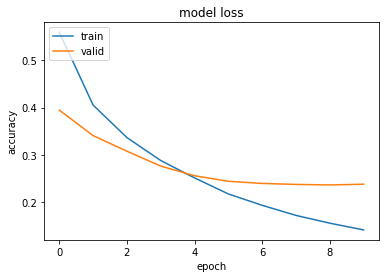

In [33]:
plt.plot(fcn_train_history.history['loss'])
plt.plot(fcn_train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

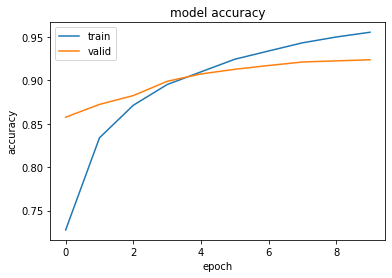

In [32]:
plt.plot(fcn_train_history.history['accuracy'])
plt.plot(fcn_train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

#### 4-4. Result

In [34]:
fcn_result = fcn_model.predict_classes(X_test)

In [35]:
print(classification_report(Y_test, fcn_result, target_names=['normal', 'abnormal']))

              precision    recall  f1-score   support

      normal       0.78      0.98      0.86     17745
    abnormal       0.91      0.45      0.60      9186

    accuracy                           0.80     26931
   macro avg       0.84      0.71      0.73     26931
weighted avg       0.82      0.80      0.78     26931

